In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime, timedelta
pd.set_option('display.max_colwidth', None)
import math


In [3]:
index_kurento_names = [
    "loadtest-webrtc-final-kurento-2p-t3medium",
    "loadtest-webrtc-final-kurento-2p-t3medium-2",
    "loadtest-webrtc-final-kurento-2p-t3medium-wait",
    "loadtest-webrtc-final-kurento-2p-t3medium-retry",
    "loadtest-webrtc-final-kurento-5p-t3medium",
    "loadtest-webrtc-final-kurento-5p-t3medium-2",
    "loadtest-webrtc-final-kurento-5p-t3medium-wait",
    "loadtest-webrtc-final-kurento-5p-t3medium-retry",
    "loadtest-webrtc-final-kurento-8p-t3medium",
    "loadtest-webrtc-final-kurento-8p-t3medium-2",
    "loadtest-webrtc-final-kurento-8p-t3medium-wait",
    "loadtest-webrtc-final-kurento-8p-t3medium-retry",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium-2",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium-wait",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium-retry",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium-2",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium-wait",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium-retry",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium-2",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium-wait",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium-retry",
]

index_mediasoup_names = [
    "loadtest-webrtc-final-mediasoup-2p-t3medium",
    "loadtest-webrtc-final-mediasoup-2p-t3medium-2",
    "loadtest-webrtc-final-mediasoup-2p-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-2p-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-5p-t3medium",
    "loadtest-webrtc-final-mediasoup-5p-t3medium-2",
    "loadtest-webrtc-final-mediasoup-5p-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-5p-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-8p-t3medium",
    "loadtest-webrtc-final-mediasoup-8p-t3medium-2",
    "loadtest-webrtc-final-mediasoup-8p-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-8p-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium-2",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium-2",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium-2",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium-retry",
]

index_livekit_names = [
    "loadtest-webrtc-final-livekit-2p-t3medium-retry",
    "loadtest-webrtc-final-livekit-8p-t3medium-retry",
    "loadtest-webrtc-final-livekit-3p-10s-t3medium-retry",
    "loadtest-webrtc-final-livekit-3p-40s-t3medium-retry",
]

index_list_names = index_kurento_names + index_mediasoup_names + index_livekit_names

node_types = ["browseremulator", "masternode", "medianode"]
packet_types = ["inbound", "outbound"]

seconds_per_fragment = 17

start_end_times = pd.read_json("dfs_final/start-end-times.json", orient="index")
start_end_times["from"] = pd.to_datetime(
    start_end_times["from"], format="ISO8601", utc=True
).dt.tz_convert("UTC")
start_end_times["to"] = pd.to_datetime(
    start_end_times["to"], format="ISO8601", utc=True
).dt.tz_convert("UTC")


def timestamp_to_secs(df_node, index, cpu_times=True):
    df_tmp = df_node.copy()
    df_tmp["@timestamp"] = pd.to_datetime(df_tmp["@timestamp"], format="ISO8601")
    tmp_serie = pd.Series(
        [df_tmp["@timestamp"].max(), start_end_times.loc[index, "to"]]
    )
    end_time = tmp_serie.min() if cpu_times else tmp_serie.max()
    df_tmp = df_tmp[df_tmp["@timestamp"] < end_time]
    tmp_serie = pd.Series(
        [df_tmp["@timestamp"].min(), start_end_times.loc[index, "from"]]
    )
    start_time = tmp_serie.max() if cpu_times else tmp_serie.min()
    df_tmp["timestamp_secs"] = (df_tmp["@timestamp"] - start_time).dt.total_seconds()
    df_tmp = df_tmp[df_tmp["timestamp_secs"] >= 0]
    return df_tmp

In [4]:
df_list = [
    pd.read_csv(f"dfs_final/{x}.csv")
    if os.path.isfile(f"dfs_final/{x}.csv")
    else pd.DataFrame()
    for x in index_list_names
]

df_user_join_list = [
    pd.read_csv(f"dfs_final/{x}-user-join.csv")
    if os.path.isfile(f"dfs_final/{x}-user-join.csv")
    else pd.DataFrame()
    for x in index_list_names
]

for i, df_user in enumerate(df_list):
    if not df_user.empty:
        index = index_list_names[i]
        user_join = df_user_join_list[i]
        start_test_time = start_end_times.loc[index, "from"]

        df_user["@timestamp"] = pd.to_datetime(df_user["@timestamp"], format="ISO8601")
        user_join["@timestamp"] = pd.to_datetime(user_join["@timestamp"], format="ISO8601")

        df_user["cut_index"] = df_user["cut_index"].astype(float)

        # cut index starts at 0 for each video
        # we asume that video starts on the timestamp that the user joins
        # each fragment lasts *seconds_per_fragment* seconds
        # for each row in user_join, change all entries with the same
        # user_join["participant"] and df_user["userFrom"]; and user_join["session"] and df_user["session"],
        # calculating its cut_index as
        # (user_join["@timestamp"] - start_test_time) + df_user["cut_index"] * seconds_per_fragment
        for _, row in user_join.iterrows():
            user_joined_at_sec = (row["@timestamp"] - start_test_time).total_seconds()
            data = df_user.loc[
                (df_user["userFrom"] == row["participant"])
                & (df_user["session"] == row["session"]),
                "cut_index"
            ] = df_user.loc[
                (df_user["userFrom"] == row["participant"])
                & (df_user["session"] == row["session"]),
                "cut_index"
            ] * seconds_per_fragment + user_joined_at_sec

index_data = []

data_types = node_types + packet_types


for i, index in enumerate(index_list_names):
    splitted = index.split("-")
    media_server = splitted[3]
    publishers = int(splitted[4][:-1])
    subscribers = int(splitted[5][:-1]) if splitted[5][-1] == "s" else 0
    users = publishers + subscribers
    repeat = "1" if splitted[-1] == "t3medium" else splitted[-1]

    index_data.append({
        "index": index,
        "media_server": media_server,
        "type": repeat,
        "publishers": publishers,
        "subscribers": subscribers,
        "users": users,
    })

index_data = pd.DataFrame(index_data)

In [5]:
# INDIVIDUAL PLOTS PARAMETERS

# Index of index_list to use
index = 45
# If there is only one metric in display, choose which one
metric = "vmaf"

show_full_range = True

# Calculations
index_name = index_list_names[index]
metric_label = metric.upper()
qoe_metrics_normalized = ["vmaf", "msssim", "ssim", "vifp", "pesq", "visqol"]
qoe_metrics_not_normalized = ["psnr", "psnrhvs", "psnrhvsm"]
metrics = qoe_metrics_normalized + qoe_metrics_not_normalized

In [ ]:
plt.rcParams["figure.figsize"] = [25, 10]
typologies = ["2p", "8p", "3p-10s", "3p-40s"]
media_nodes = ["kurento", "livekit"]
colors = ["blue", "red"]
for typology in typologies:
    for media_node in media_nodes:
        fig, ax = plt.subplots()
        target_names = filter(
            lambda x: typology in x and media_node in x and "retry" in x, index_list_names
        )
        #max_x = -1
        for i, target_name in enumerate(target_names):
            df_tmp = df_list[index_list_names.index(target_name)].copy()
            #df_tmp = pd.read_csv(f"dfs_final/{target_name}.csv")
            user_join = pd.read_csv(f"dfs_final/{target_name}-user-join.csv")
            cpu_mem = pd.read_csv(f"dfs_final/{target_name}-medianode.csv")
            user_join = timestamp_to_secs(user_join, target_name)
            cpu_mem = timestamp_to_secs(cpu_mem, target_name)
            cpu_mem = cpu_mem.drop(columns=["@timestamp", "memory"]).dropna()
            # remove entries with cpu < 0.001
            # df_node = df_node[df_node["cpu"] > 0.001]
            #df_node = timestamp_to_secs(df_node, target_name)
            # aproximate cut_index to the nearest 10 seconds
            max_timestamp = df_tmp["cut_index"].max()
            # if df_tmp["cut_index"].max() > 8000:
            #     #df_tmp["cut_index"] = df_tmp["cut_index"].round(-3)
            # #elif df_tmp["cut_index"].max() > 1000:
            #     #df_tmp["cut_index"] = df_tmp["cut_index"].round(-2)
            # else:
            df_tmp["cut_index"] = df_tmp["cut_index"].round(-1)
            df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)

            plot_name = target_name
            timestamp_user_values = user_join["timestamp_secs"].values
            # fill the timestamp_user_values with the last value to make the plot continuous

            timestamp_user_values = np.append(timestamp_user_values, max_timestamp)
            count = range(1, len(timestamp_user_values) + 1)
            if i == 0:
                ax2 = ax.twinx()
                ax2.plot(timestamp_user_values, count, color="red", label="user count", linestyle="--")
                ax2.set_ylabel("user count")
                #ax3 = ax.twinx()
                ax.plot(cpu_mem["timestamp_secs"], cpu_mem["cpu"], color="green", label="cpu", linestyle="--")
                #ax2.set_ylabel("cpu")


            if not df_mean.empty:
                for metric in qoe_metrics_normalized:
                    # TODO: Probar usando eje X user_count
                    # TODO: Calcular media y std
                    # TODO: Cuanto tarda en meterse X numero de usuarios en un media server
                    # TODO: Tiempo de conexión vs número de usuarios (a lo mejor meter CPU)
                    ax.plot(df_mean.index, df_mean[metric], label=metric)

        ax.set_xlabel("seconds")
        ax.set_ylabel("QoE (normalized)\nCPU usage (%)")
        ax.grid()
        ax.set_ylim(-0.5, 1.05)
        ax.set_yticks(np.arange(-0.5, 1.05, 0.05))

        fig.suptitle(f"QoE over time ({media_node}, {typology})")
        fig.legend(loc="right")
        fig.savefig(f"images_final/{typology}_{media_node}_qoe.png")

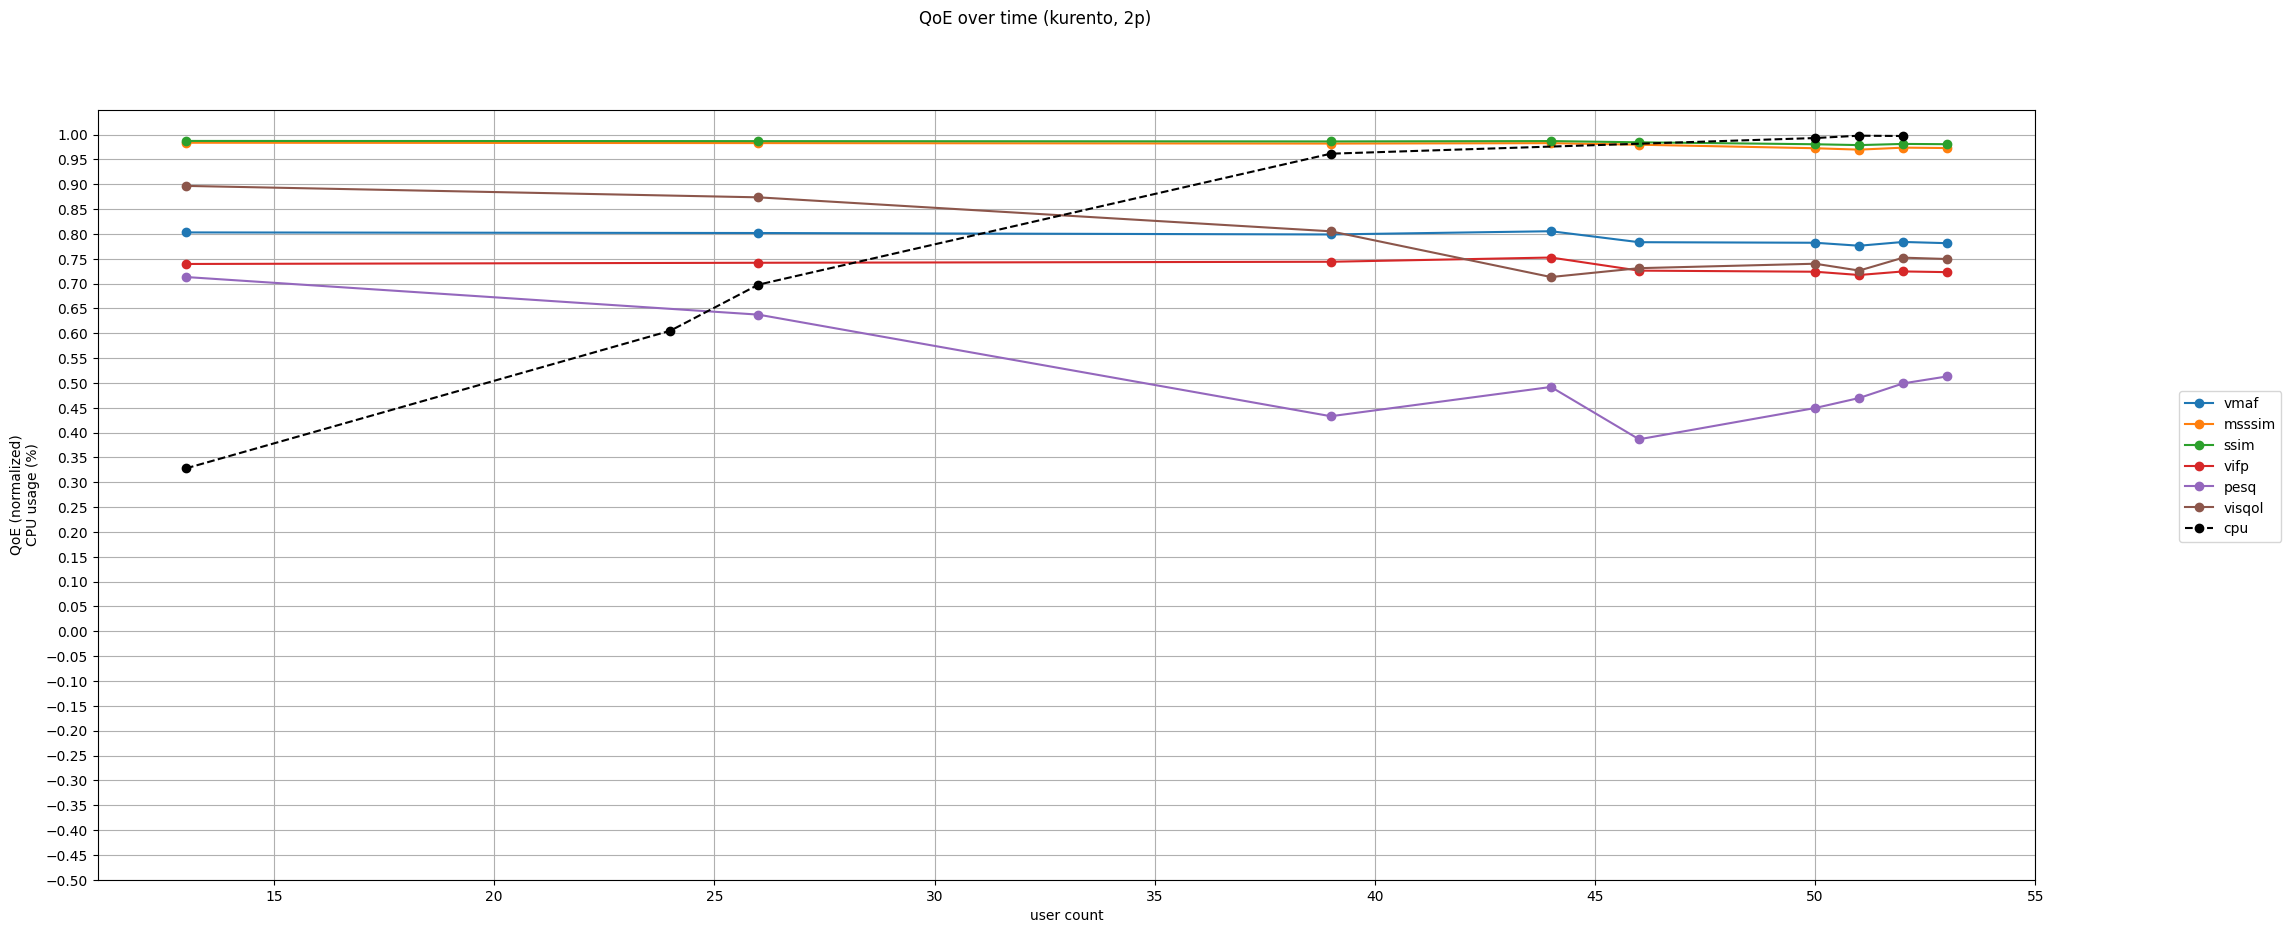

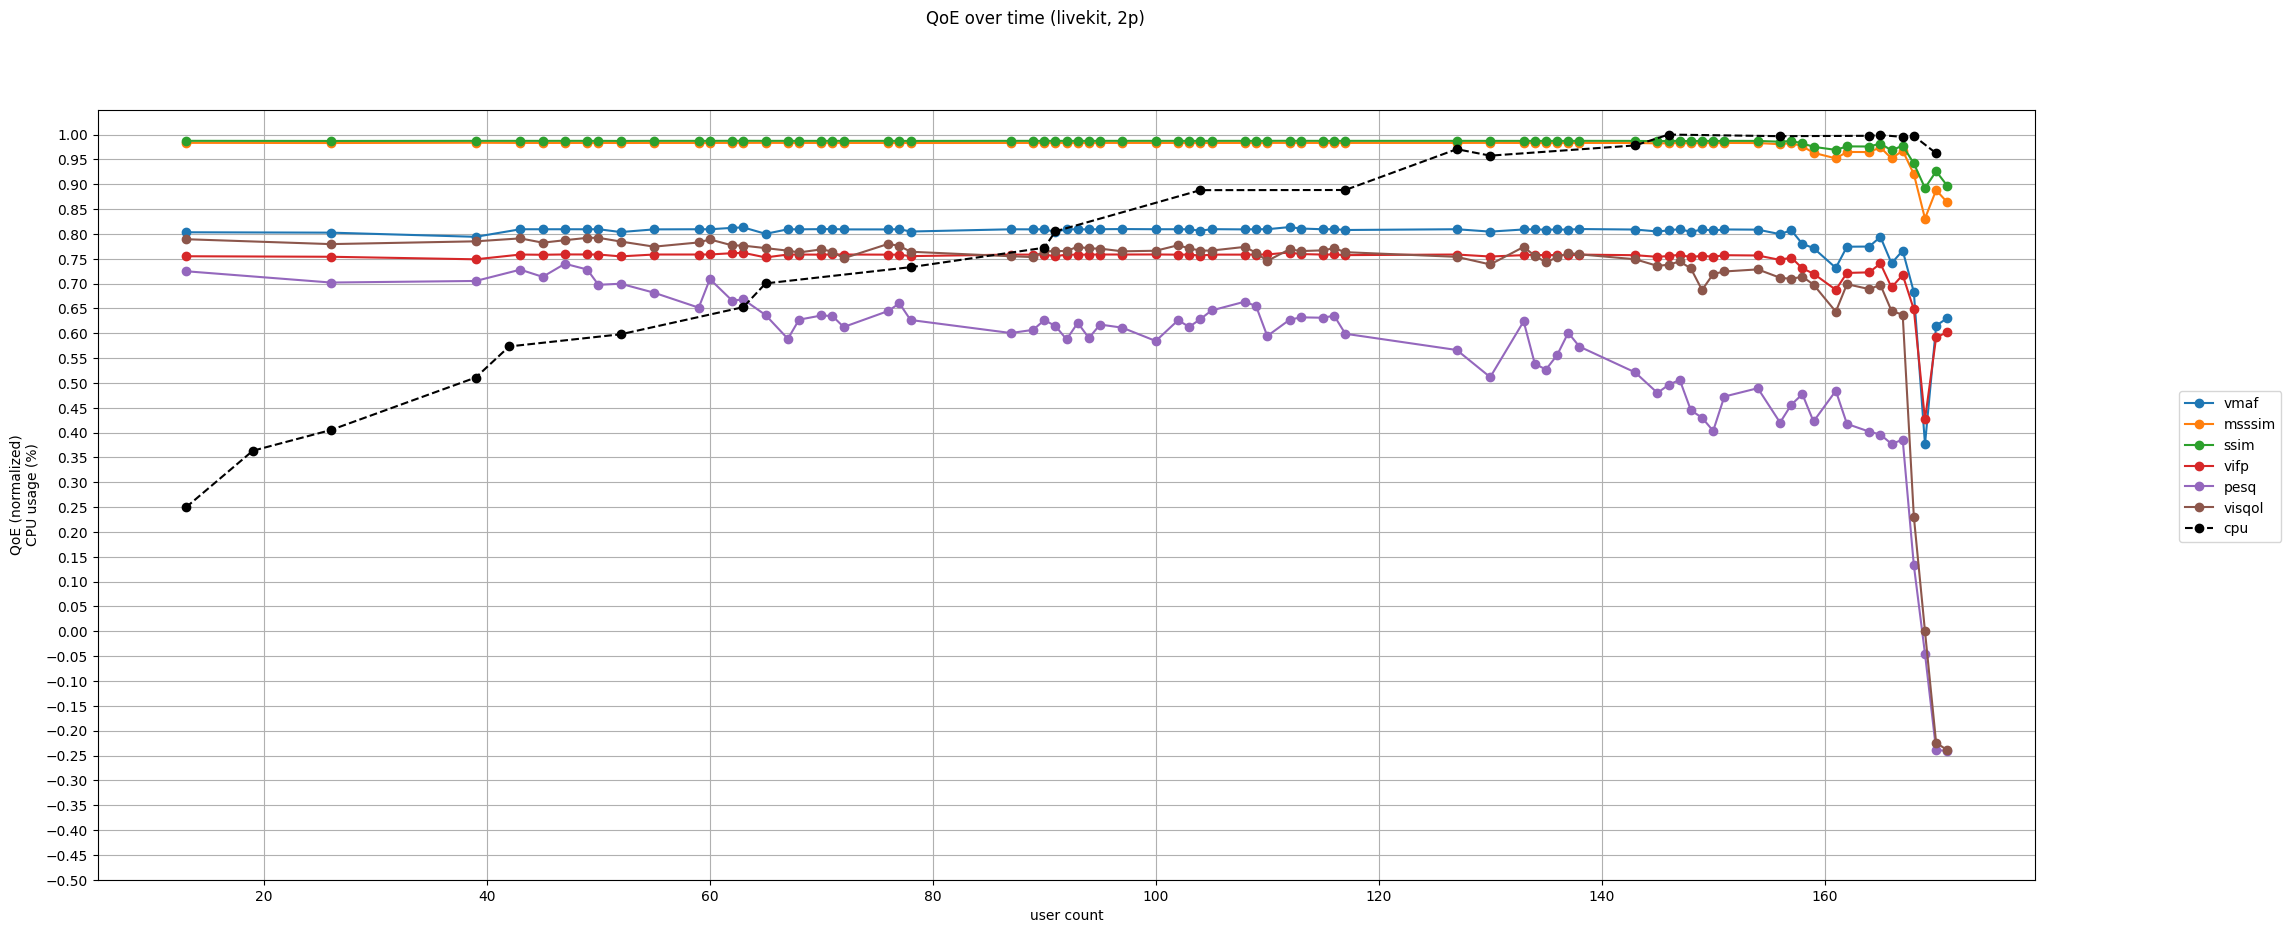

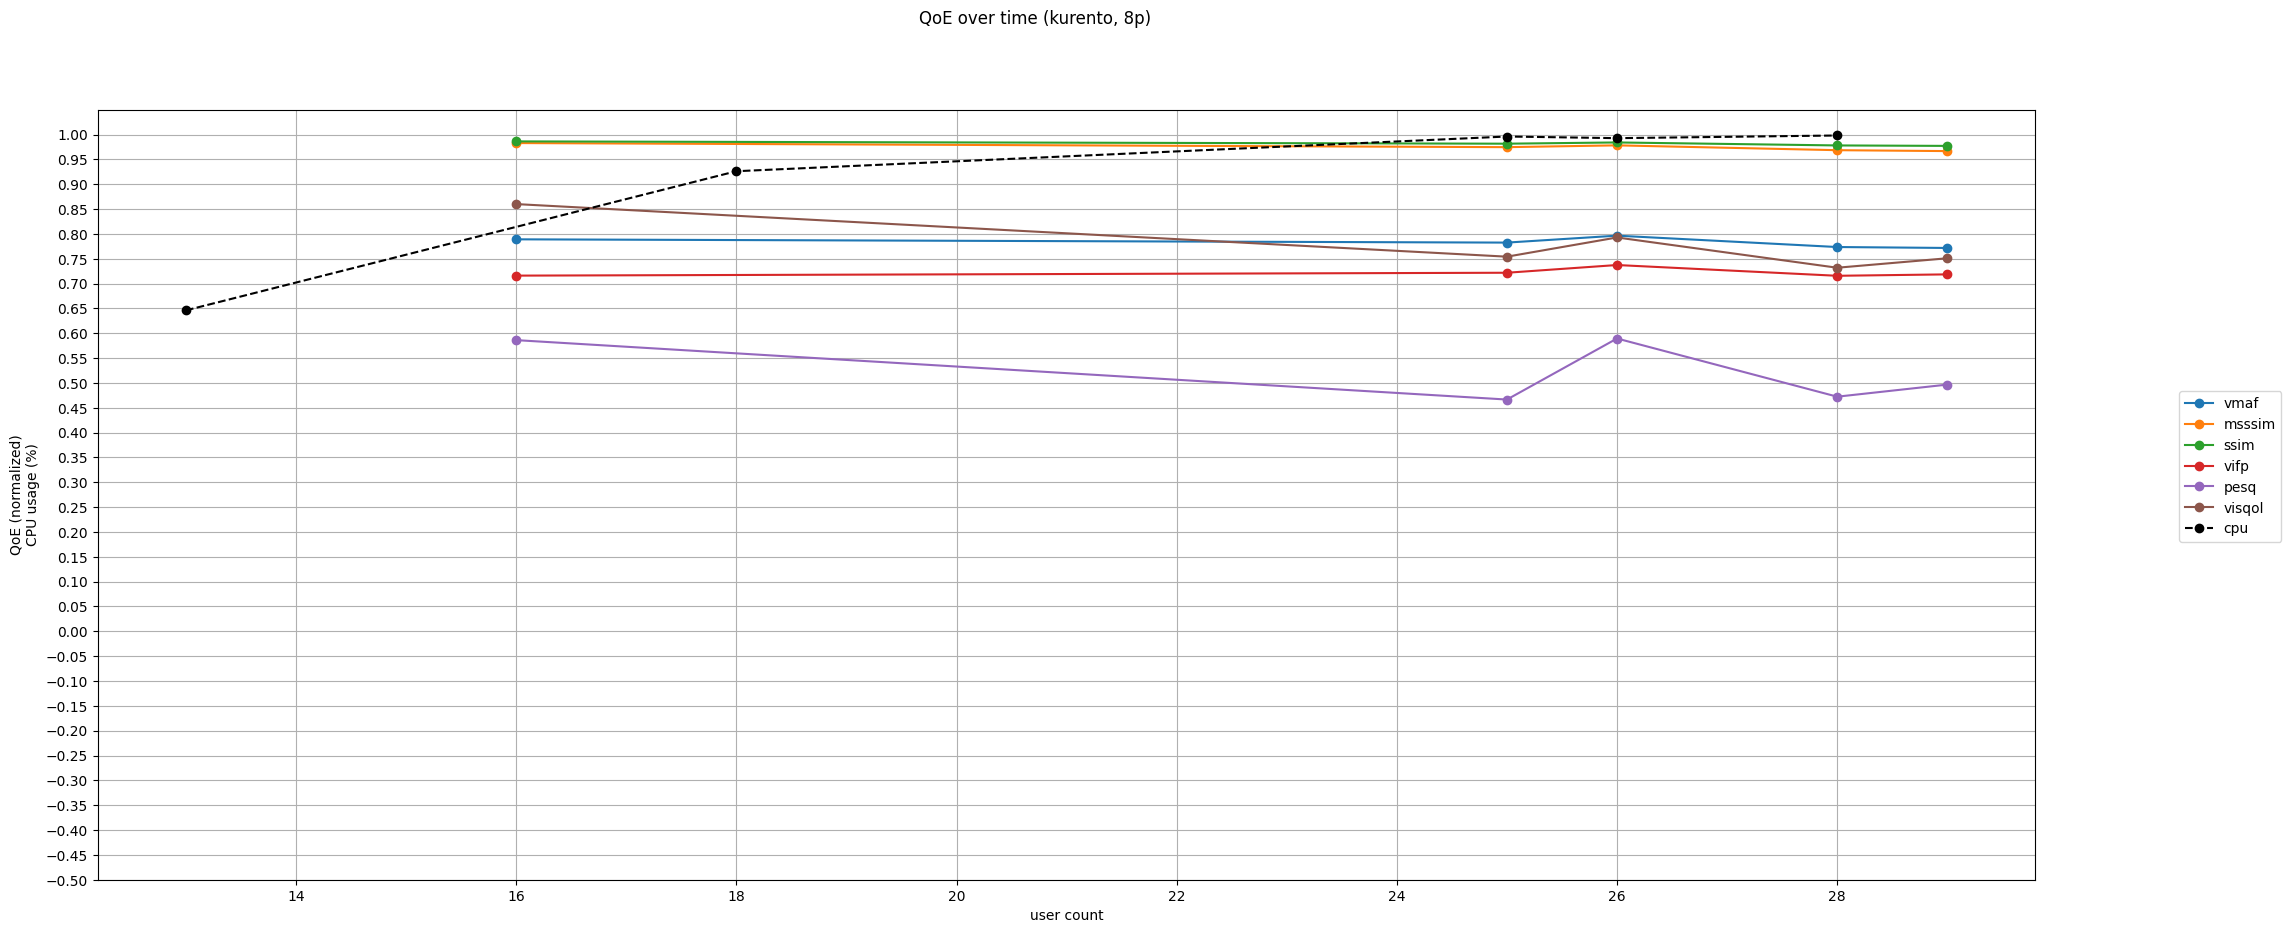

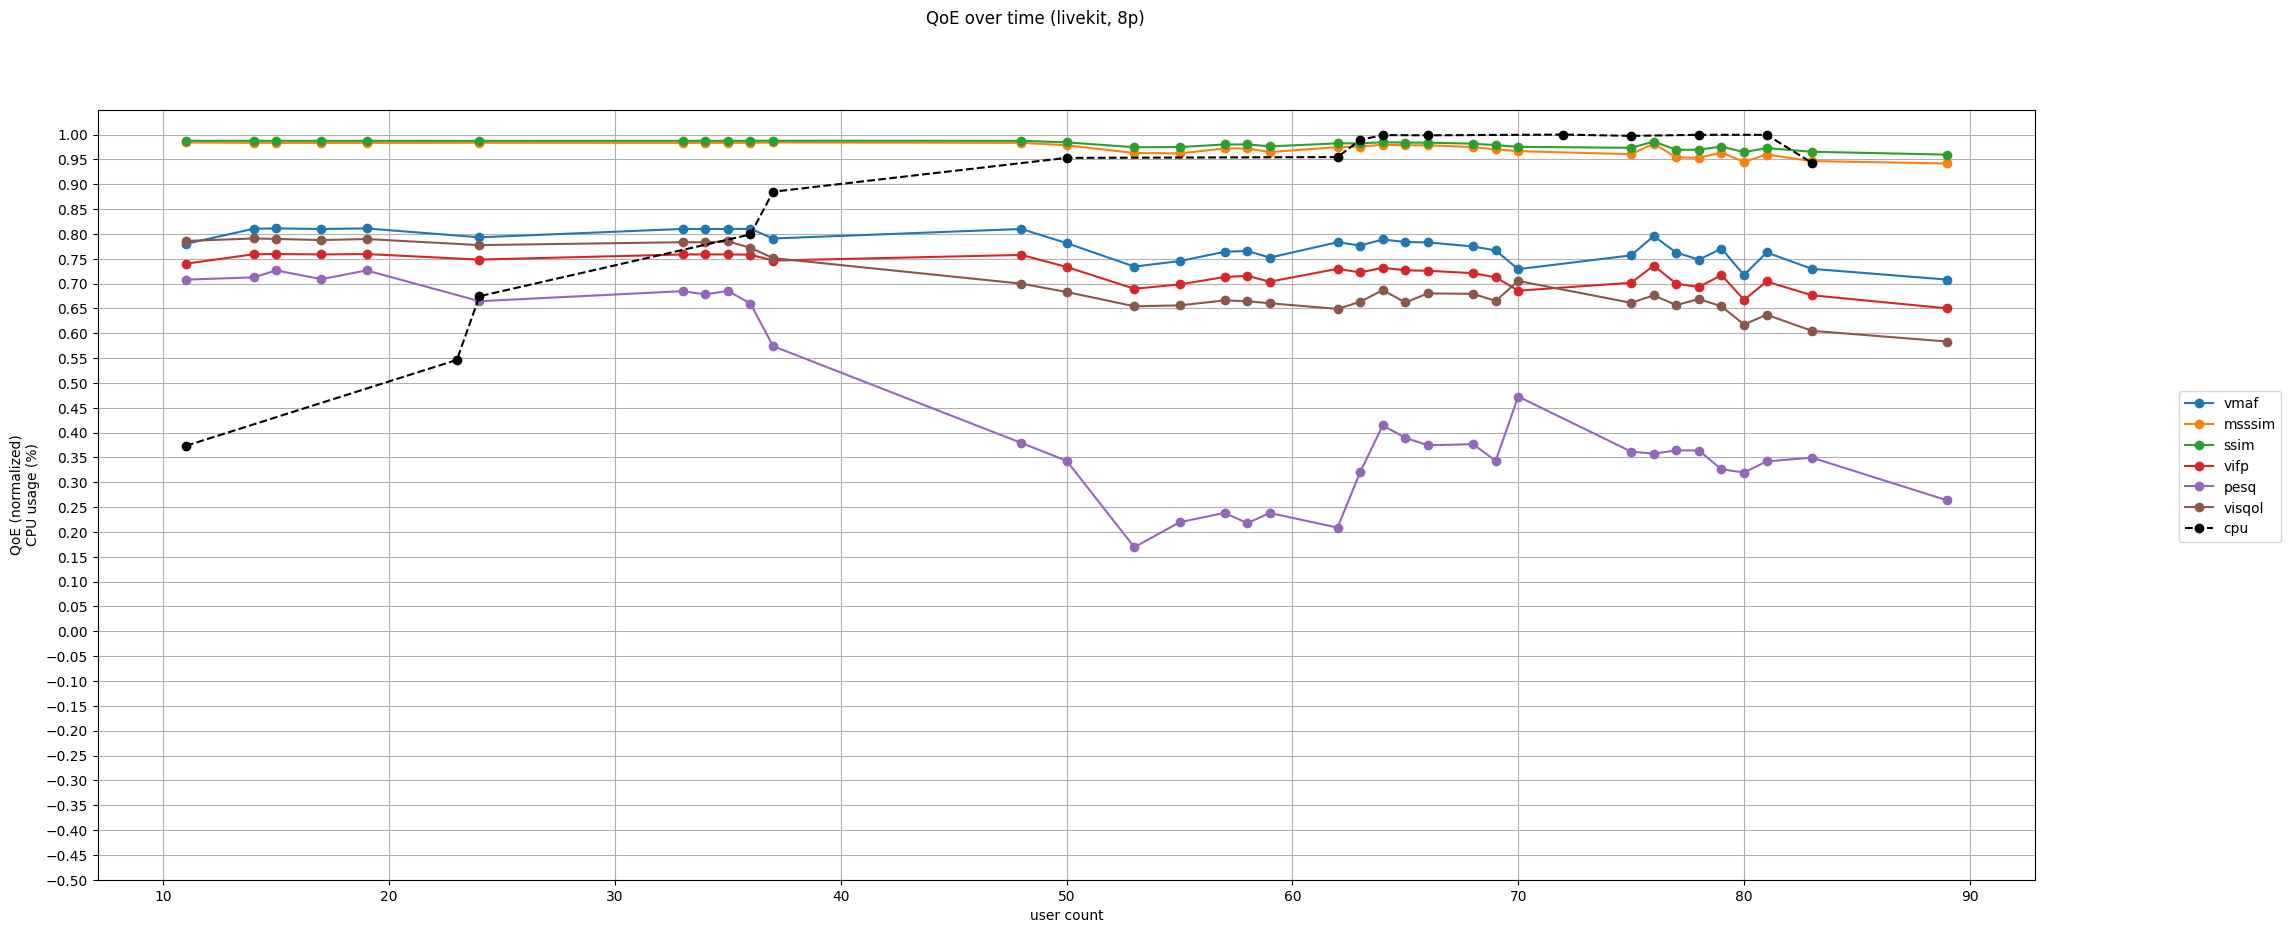

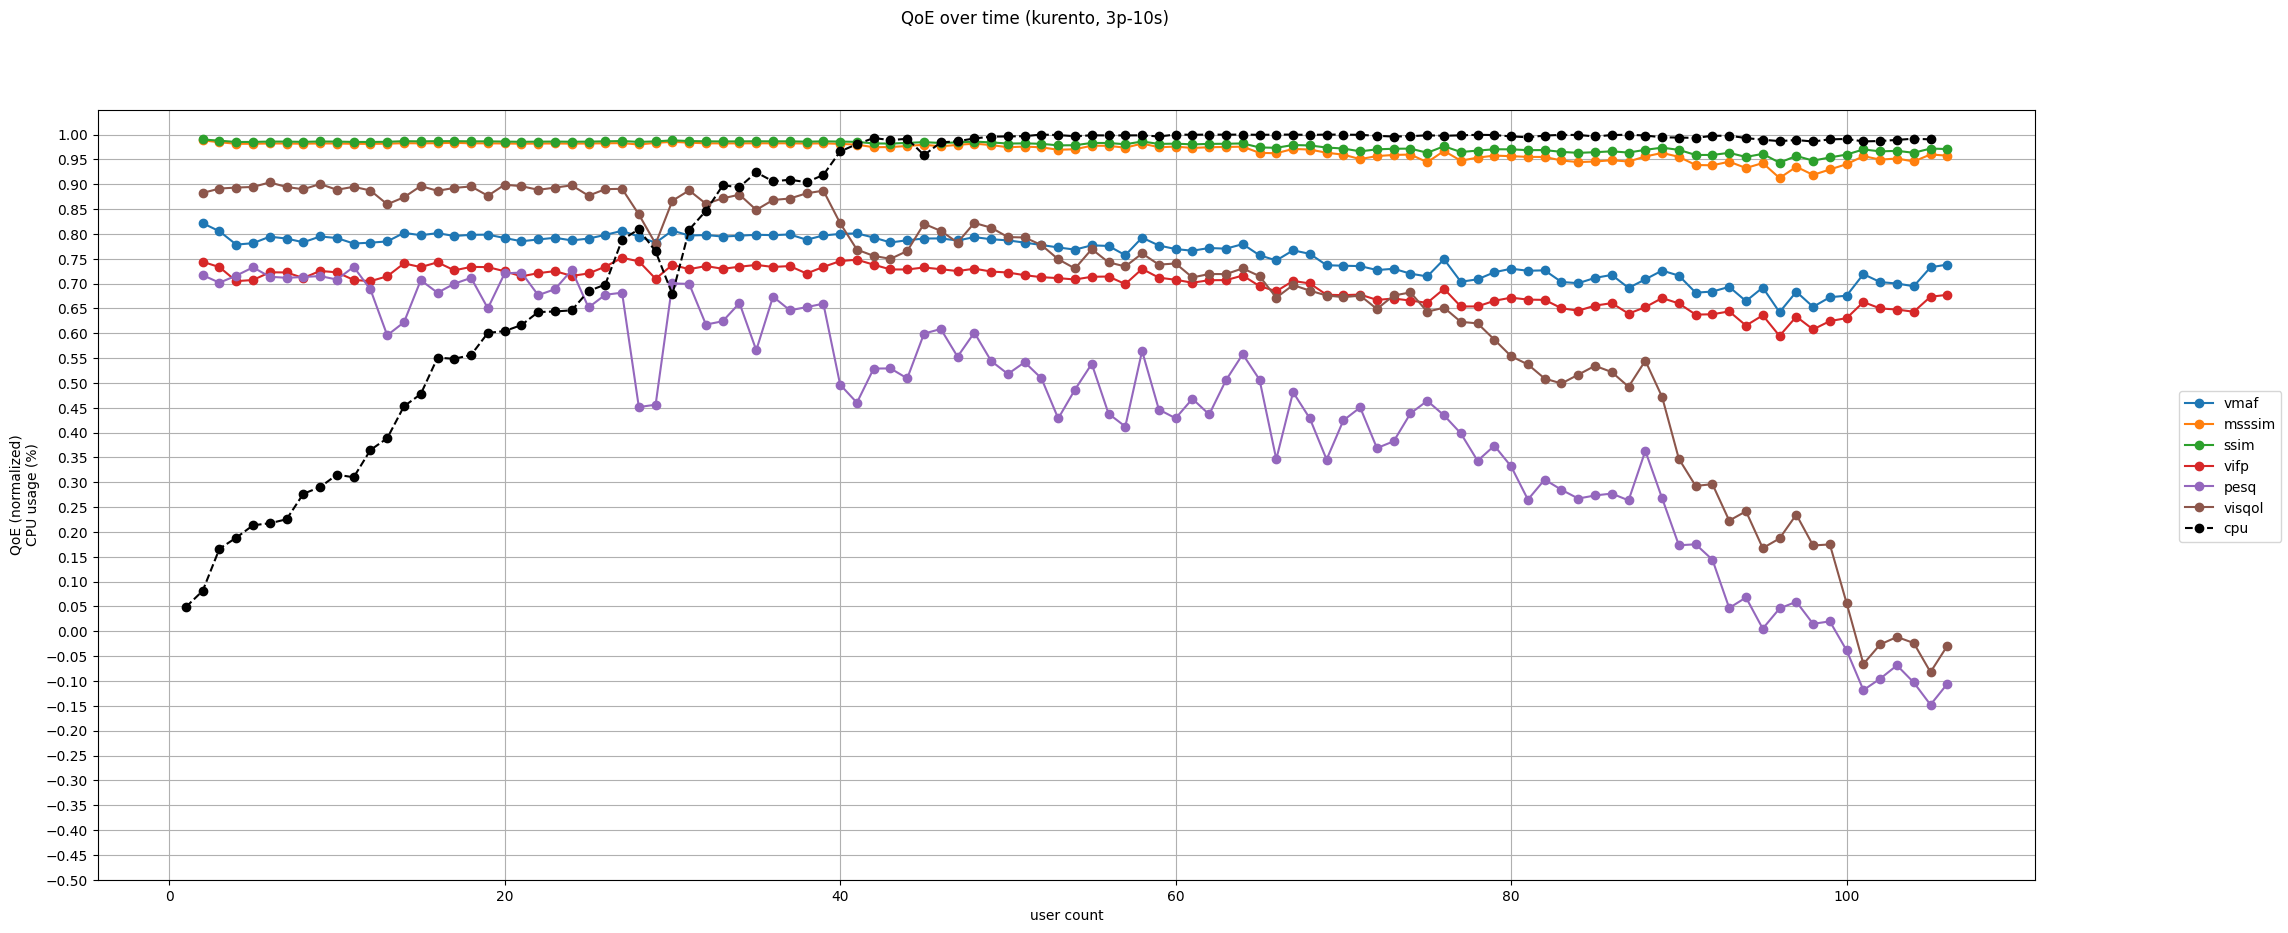

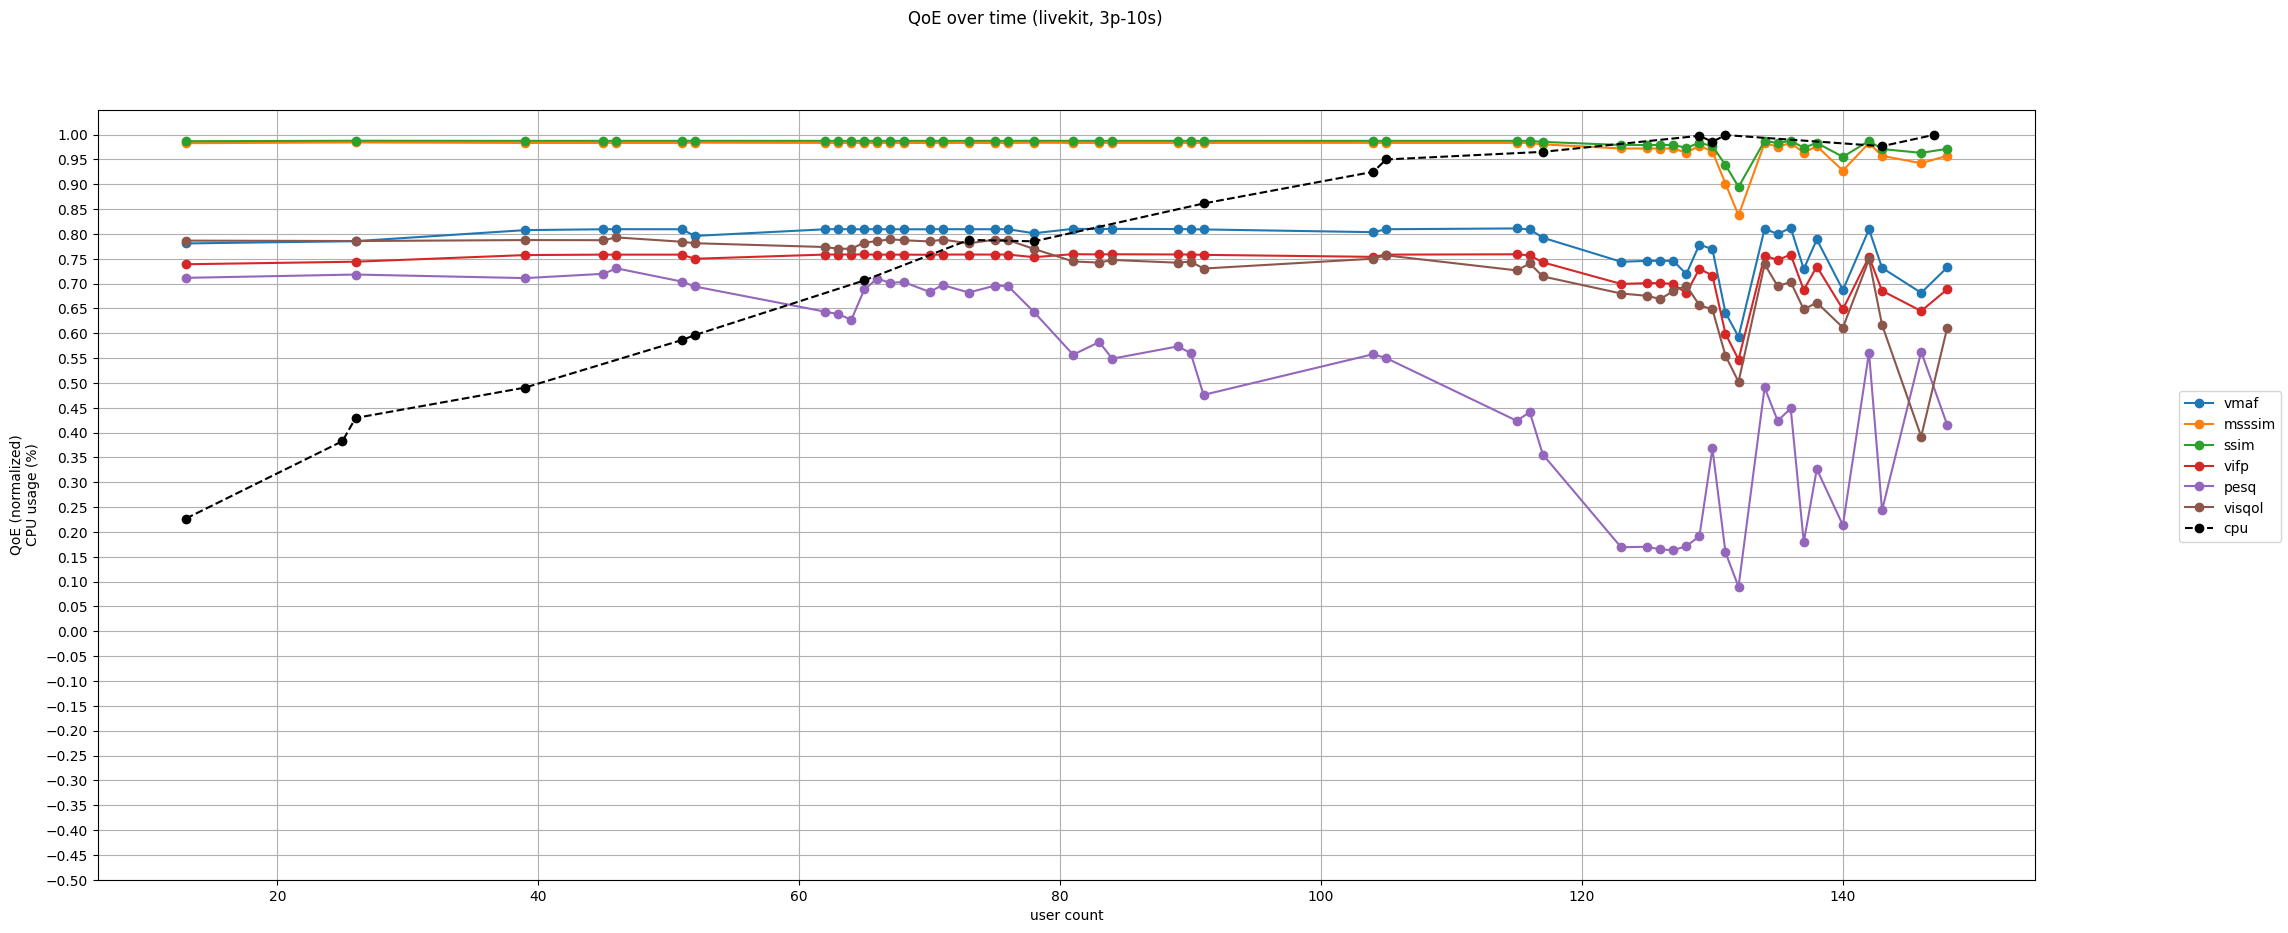

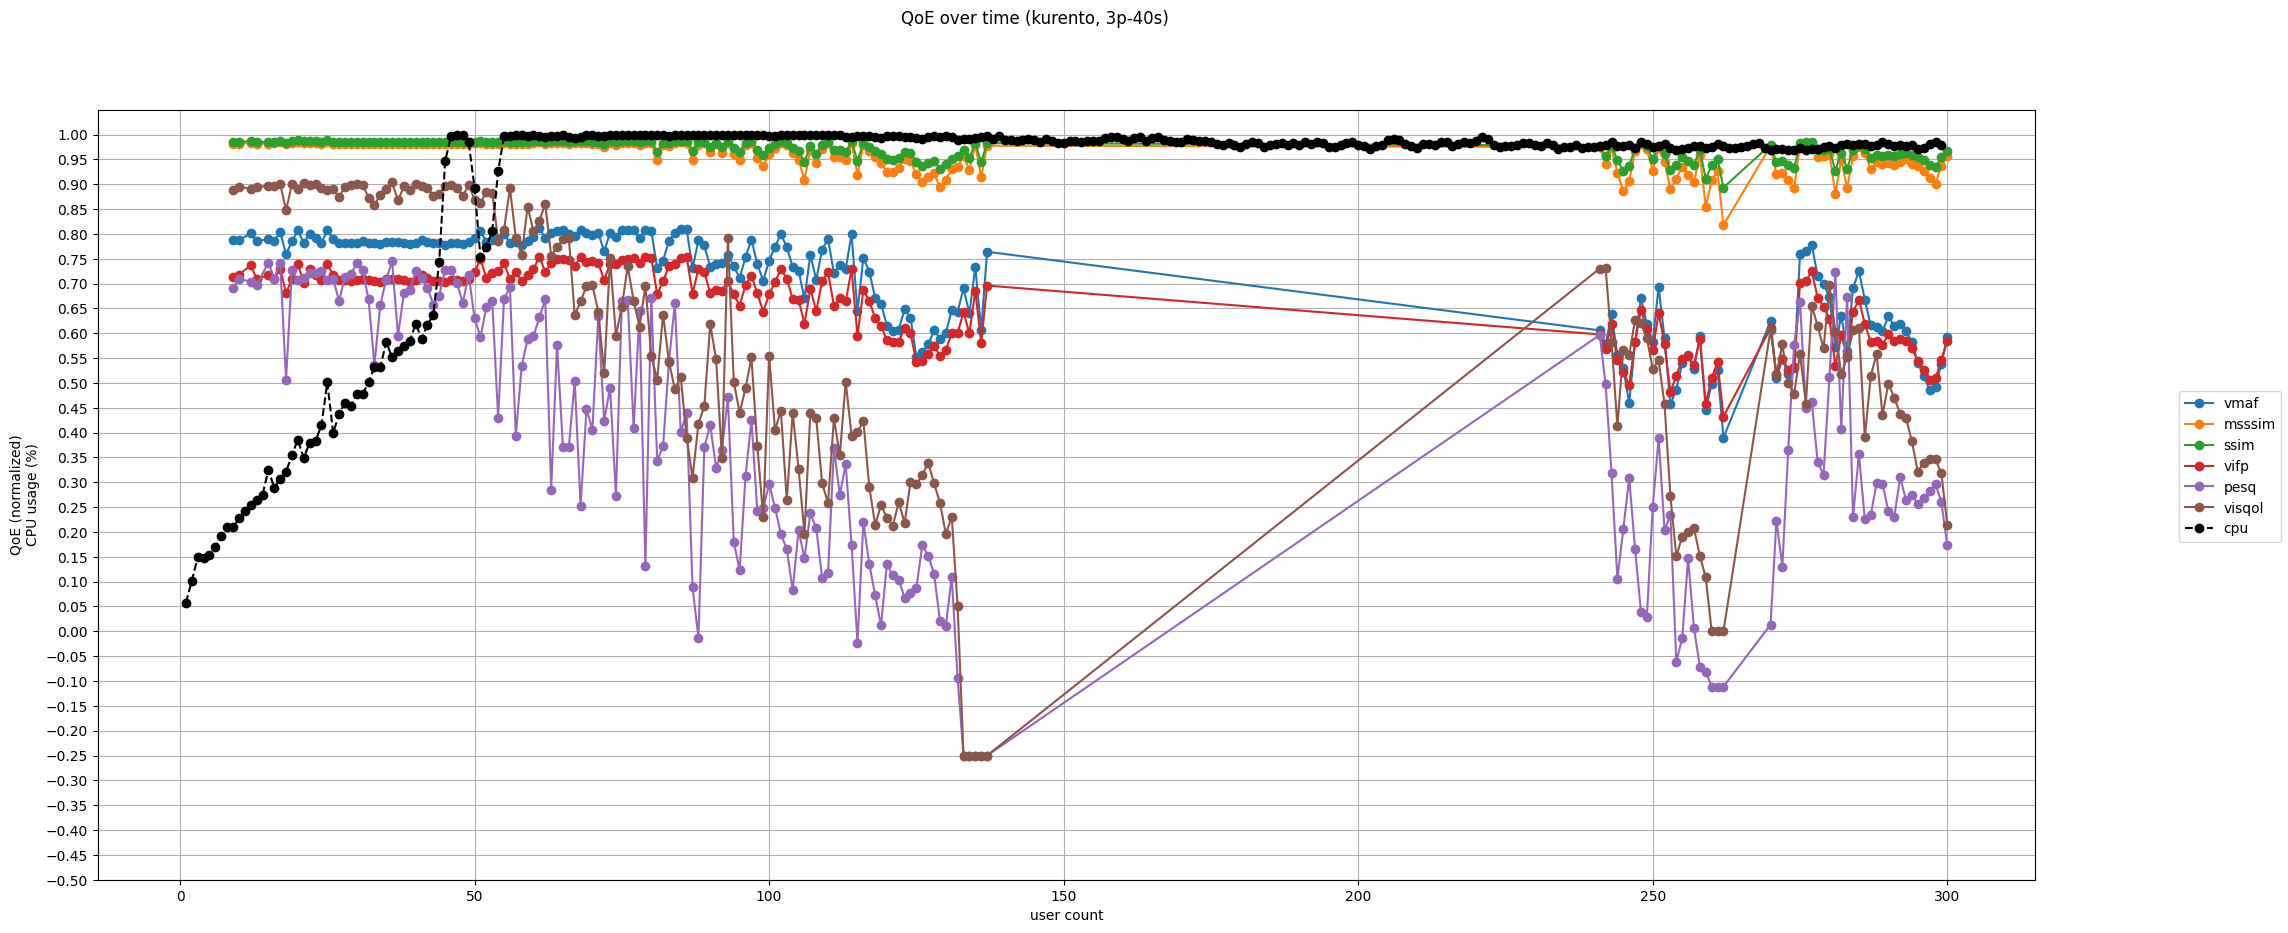

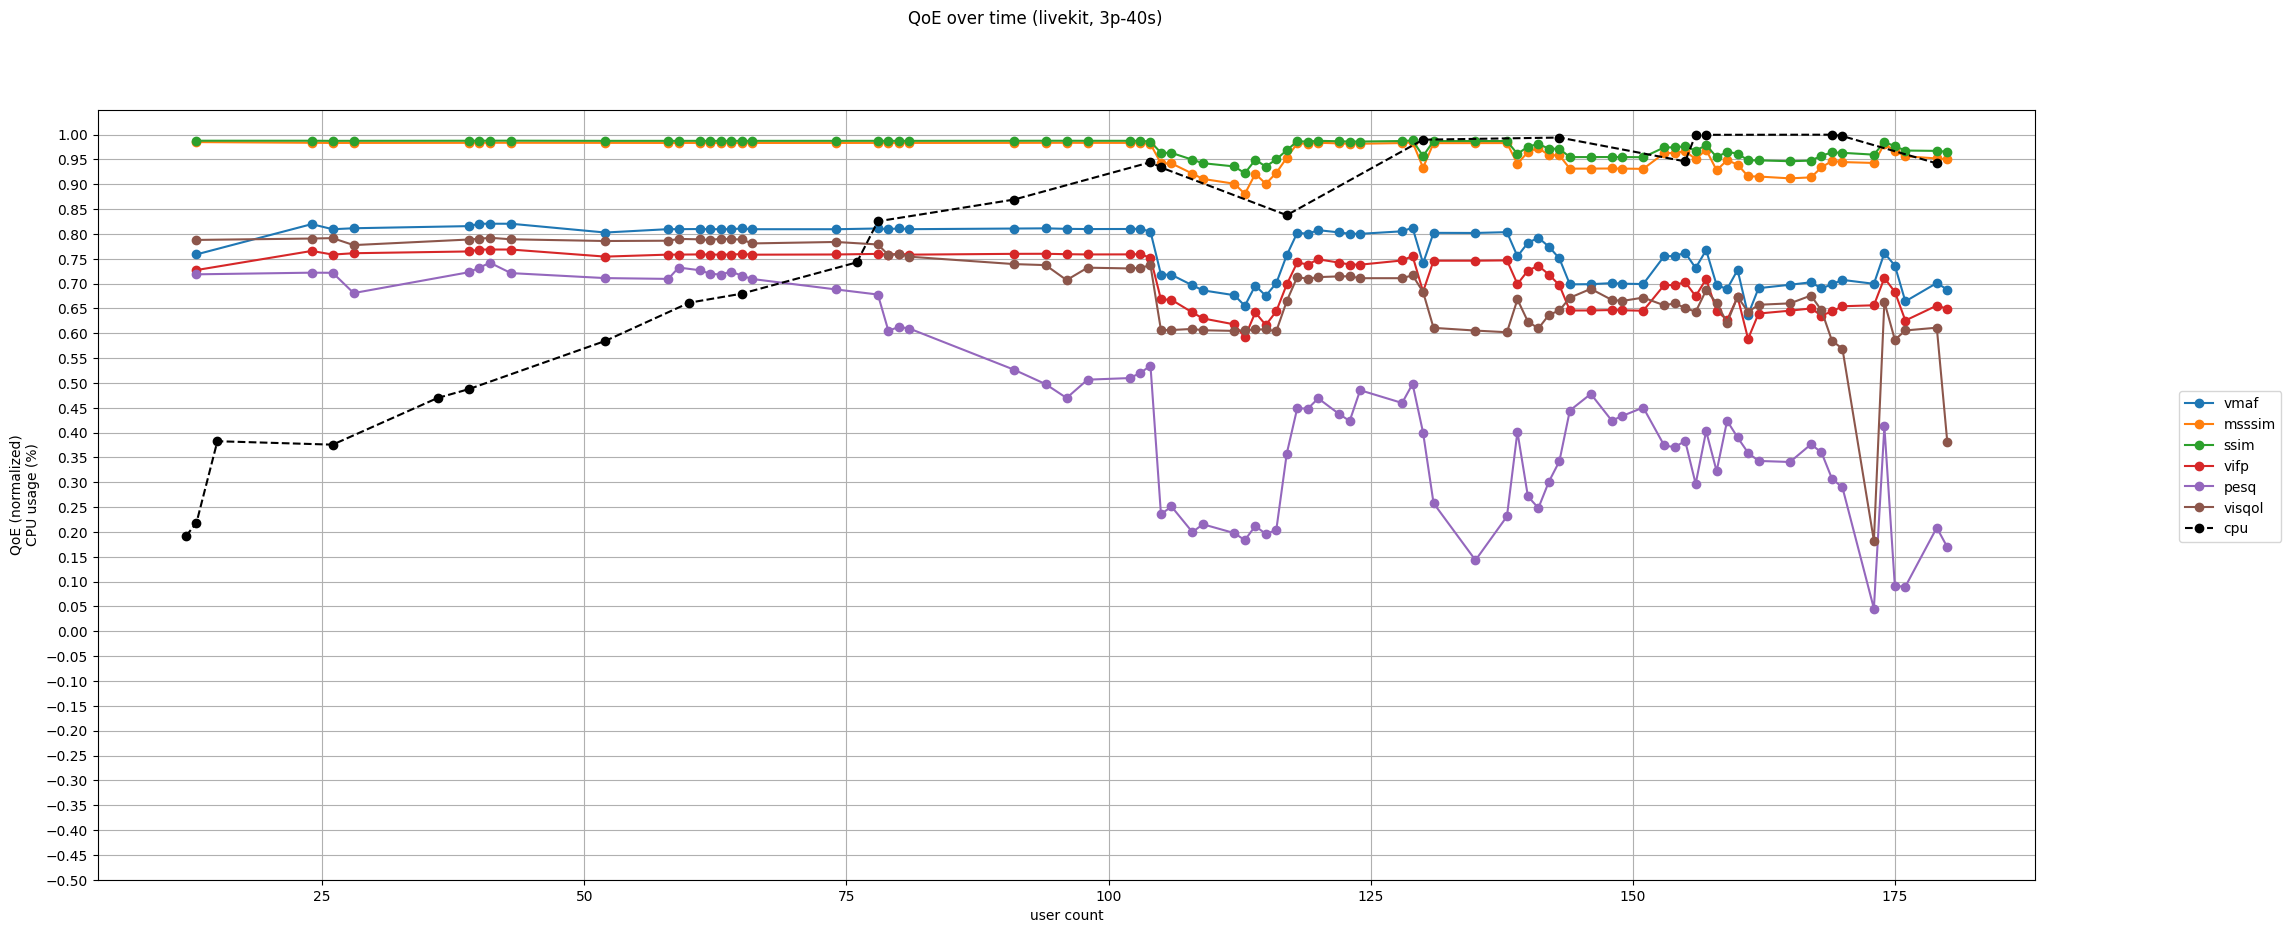

In [9]:
plt.rcParams["figure.figsize"] = [25, 10]
typologies = ["2p", "8p", "3p-10s", "3p-40s"]
media_nodes = ["kurento", "livekit"]
colors = ["blue", "red"]
for typology in typologies:
    for media_node in media_nodes:

        fig, ax = plt.subplots()
        #also draw scatterplot
        #figs, axs = plt.subplots()
        target_names = filter(
            lambda x: typology in x and media_node in x and "retry" in x, index_list_names
        )
        #max_x = -1
        for i, target_name in enumerate(target_names):
            df_tmp = df_list[index_list_names.index(target_name)].copy()
            #df_tmp = pd.read_csv(f"dfs_final/{target_name}.csv")
            user_join = pd.read_csv(f"dfs_final/{target_name}-user-join.csv")
            cpu_mem = pd.read_csv(f"dfs_final/{target_name}-medianode.csv")
            user_join = timestamp_to_secs(user_join, target_name)
            cpu_mem = timestamp_to_secs(cpu_mem, target_name)
            cpu_mem = cpu_mem.drop(columns=["memory"]).dropna()
            cpu_mem = cpu_mem.sort_values(by="@timestamp")
            cpu_mem['user_count'] = [len(user_join[user_join['@timestamp'] <= ts]) for ts in cpu_mem['@timestamp']]
            cpu_mem = cpu_mem[cpu_mem['user_count'] > 0]
            cpu_mem = cpu_mem.groupby('user_count').mean(numeric_only=True)
            # remove entries with cpu < 0.001
            # df_node = df_node[df_node["cpu"] > 0.001]
            #df_node = timestamp_to_secs(df_node, target_name)
            # aproximate cut_index to the nearest 10 seconds
            # max_timestamp = df_tmp["cut_index"].max()
            # if df_tmp["cut_index"].max() > 8000:
            #     #df_tmp["cut_index"] = df_tmp["cut_index"].round(-3)
            # #elif df_tmp["cut_index"].max() > 1000:
            #     #df_tmp["cut_index"] = df_tmp["cut_index"].round(-2)
            # else:
            # df_tmp["cut_index"] = df_tmp["cut_index"].round(-1)
            # for metric in qoe_metrics_normalized:
            #     axs.scatter(df_tmp["user_count"], df_tmp[metric], label=metric)
            df_mean = df_tmp.groupby(["user_count"]).mean(numeric_only=True)

            plot_name = target_name

            if not df_mean.empty:
                for metric in qoe_metrics_normalized:
                    # TODO: Probar usando eje X user_count
                    # TODO: Calcular media y std
                    # TODO: Cuanto tarda en meterse X numero de usuarios en un media server
                    # TODO: Tiempo de conexión vs número de usuarios (a lo mejor meter CPU)
                    ax.plot(df_mean.index, df_mean[metric], label=metric, marker='o')
            ax.plot(cpu_mem.index, cpu_mem["cpu"], label="cpu", linestyle="--", color="black", marker='o')

        ax.set_xlabel("user count")
        ax.set_ylabel("QoE (normalized)\nCPU usage (%)")
        ax.grid()
        ax.set_ylim(-0.5, 1.05)
        ax.set_yticks(np.arange(-0.5, 1.05, 0.05))

        fig.suptitle(f"QoE over time ({media_node}, {typology})")
        fig.legend(loc="right")
        fig.savefig(f"images_final/{typology}_{media_node}_qoe_usercount.png")

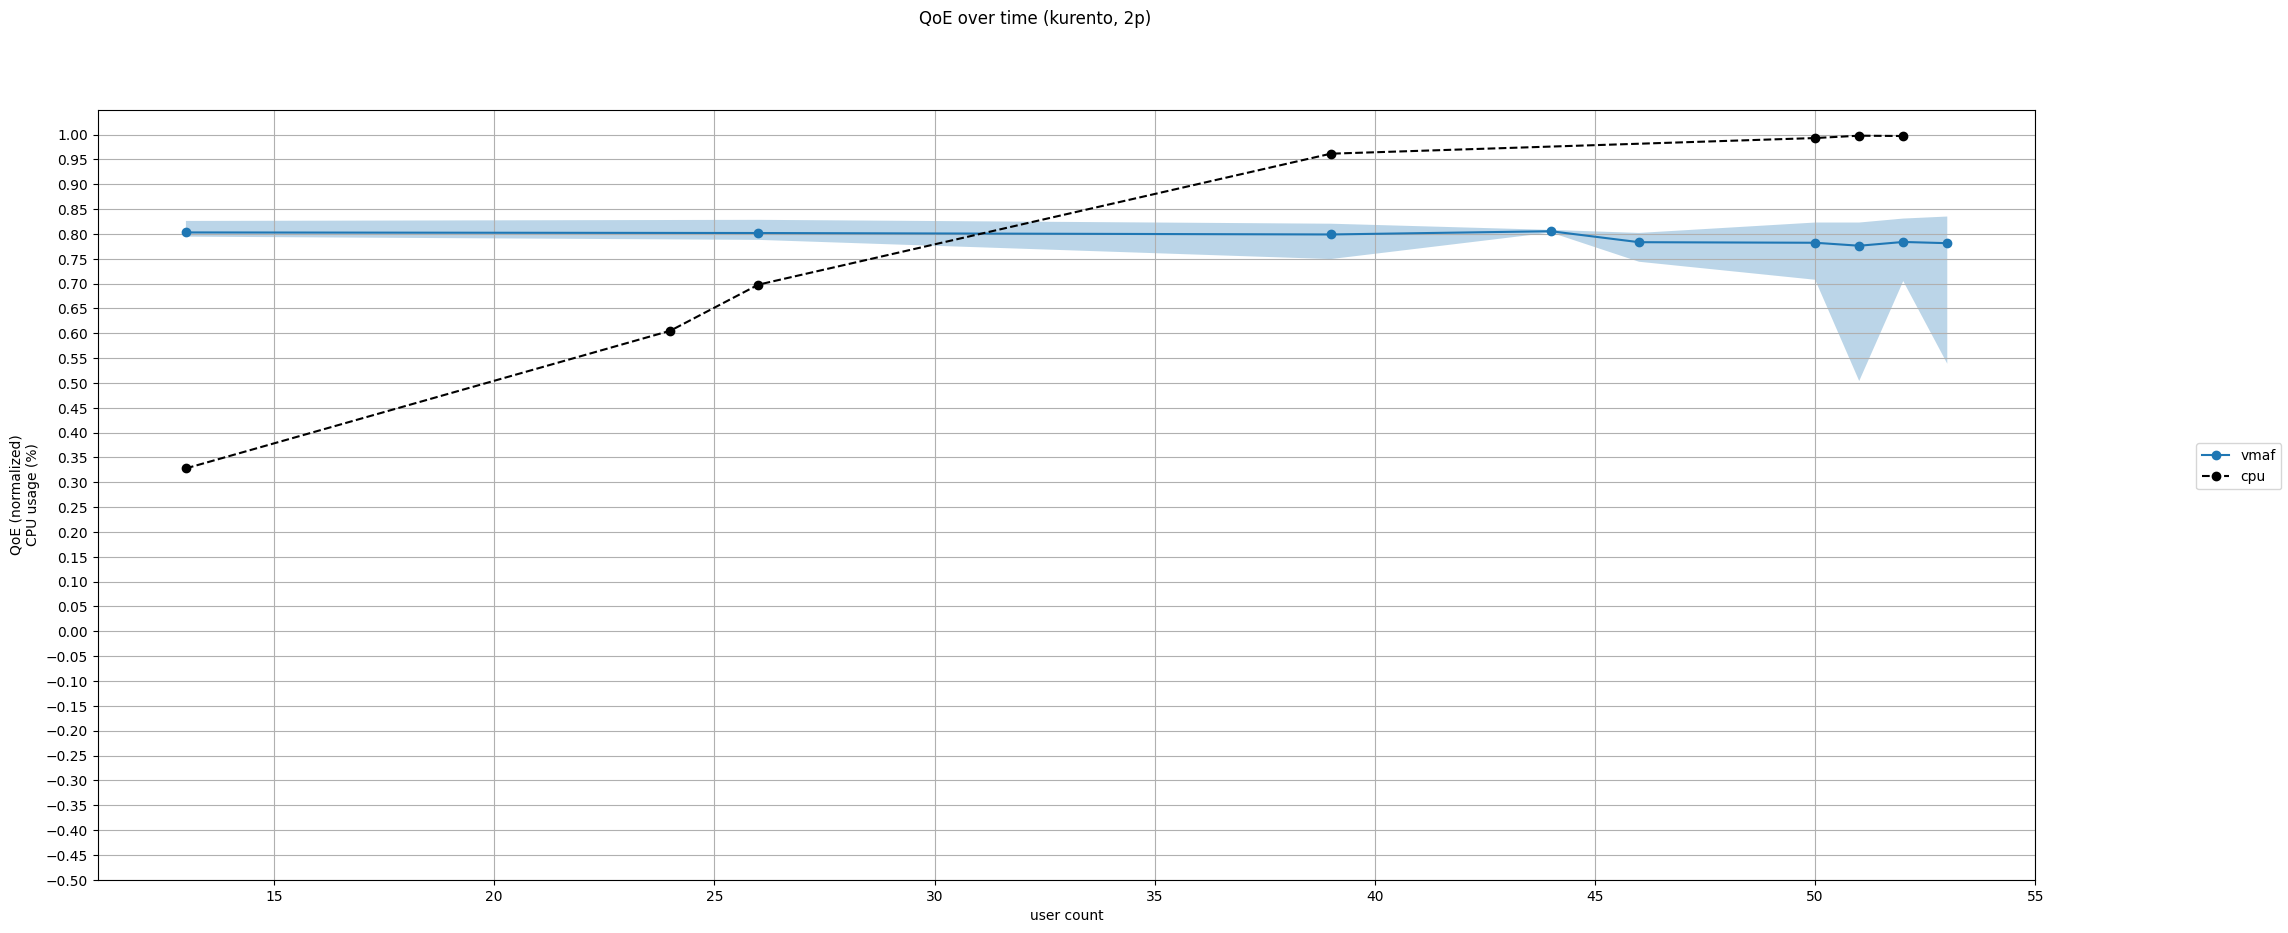

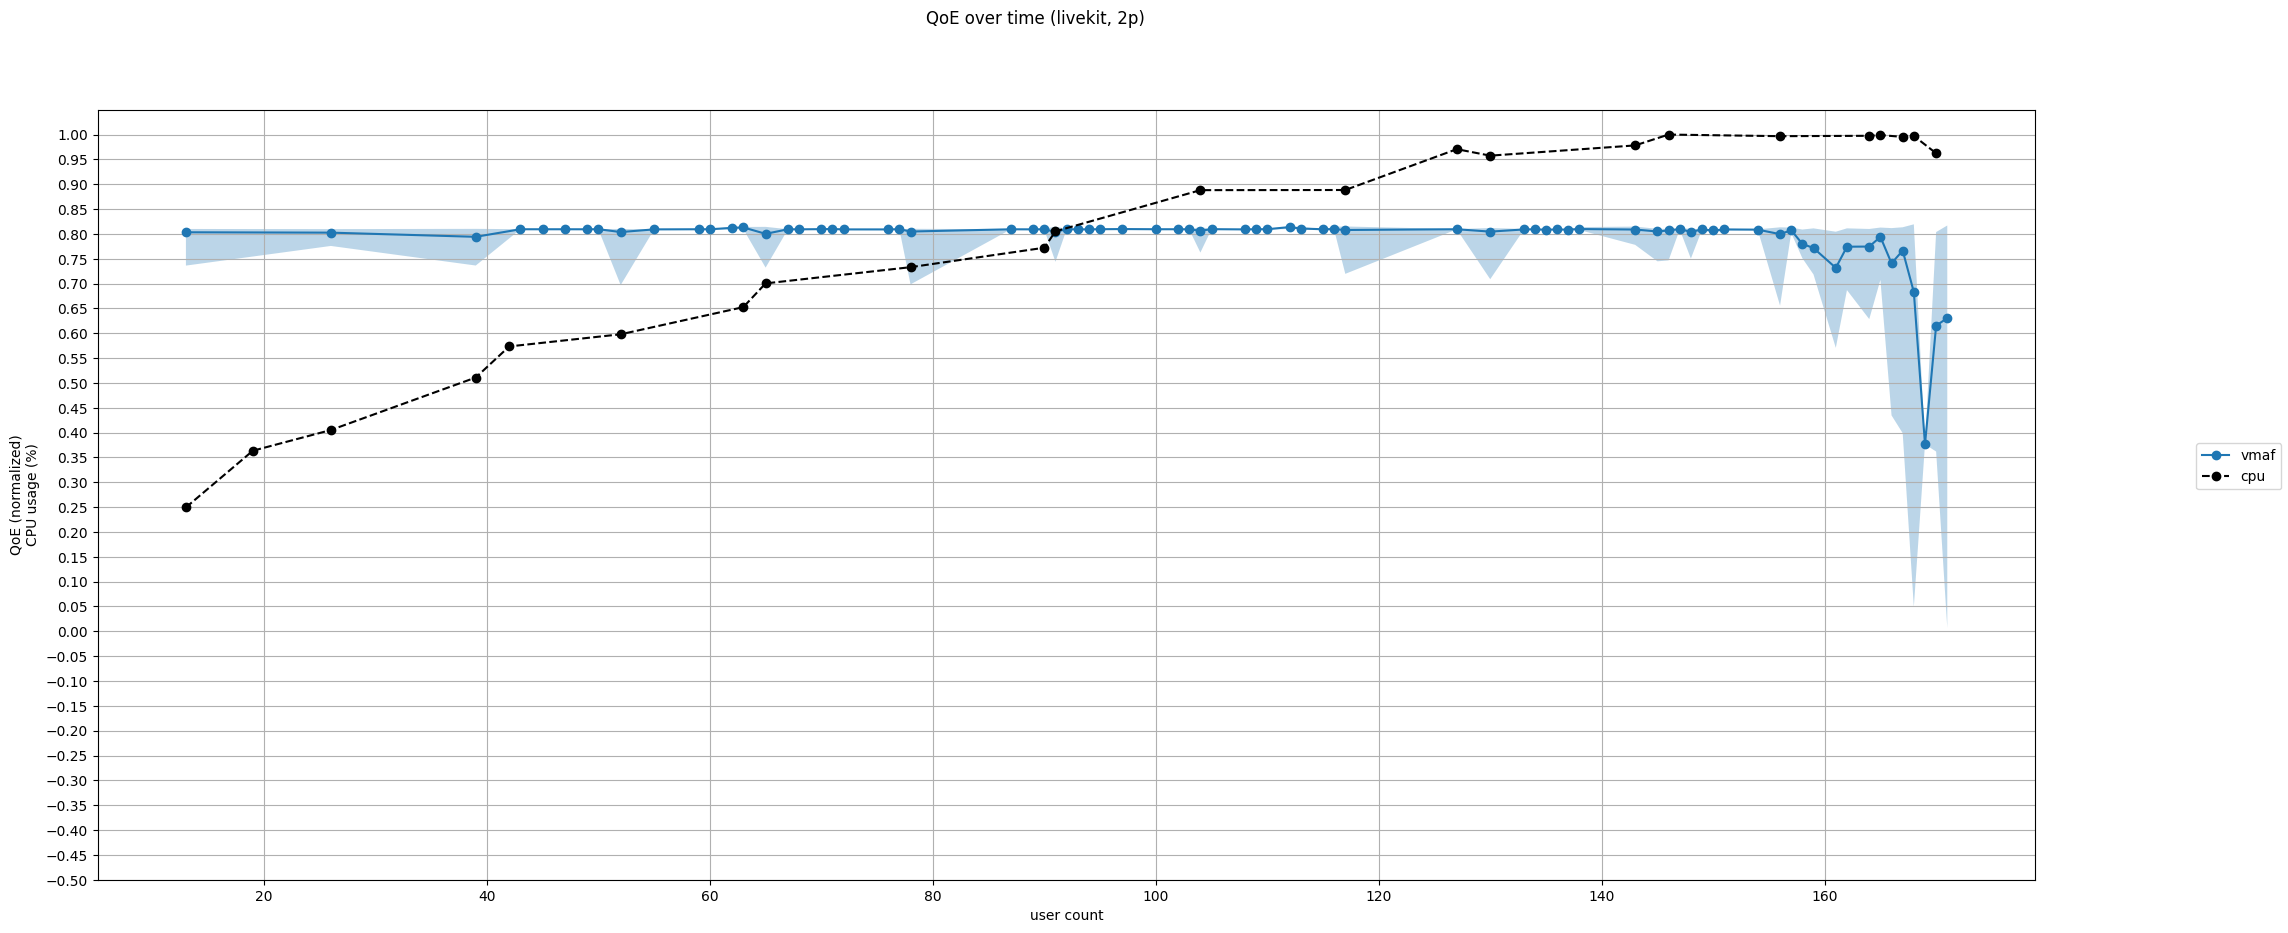

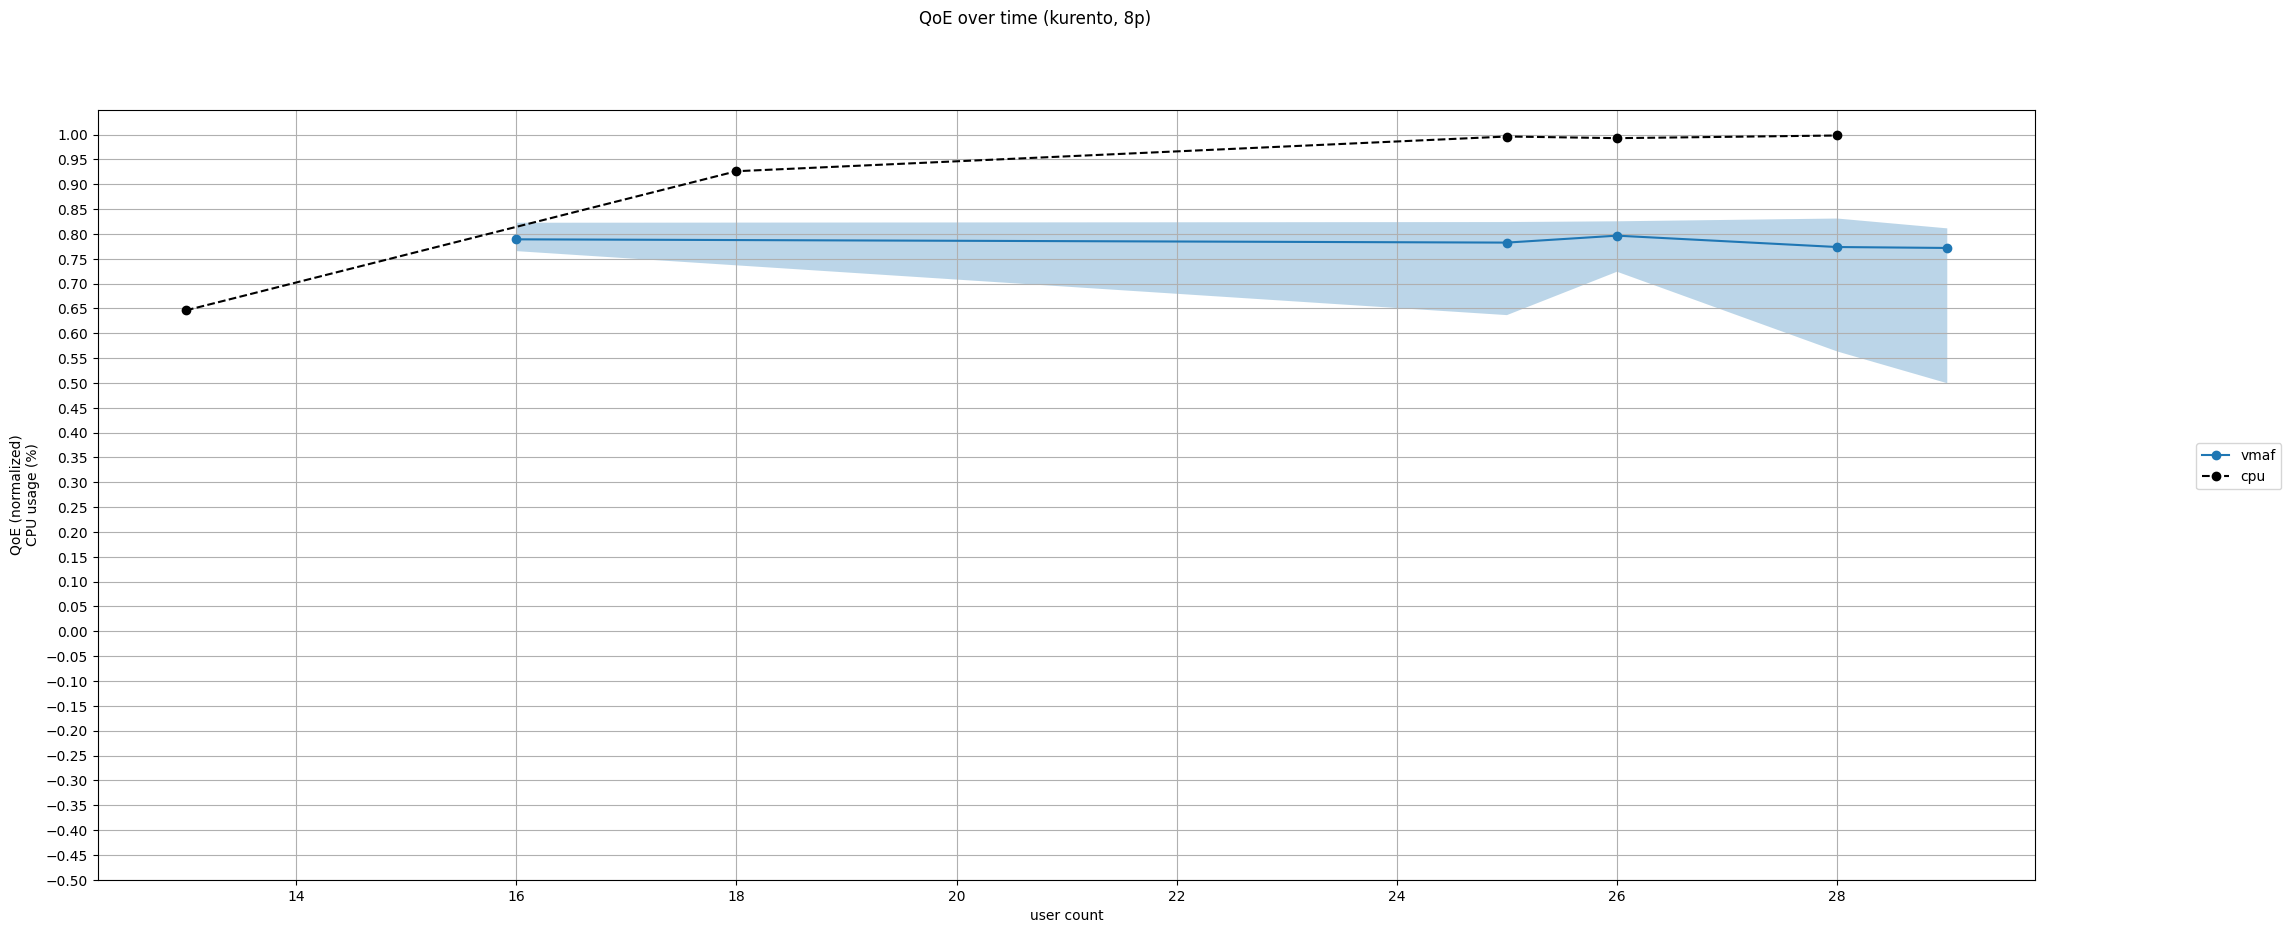

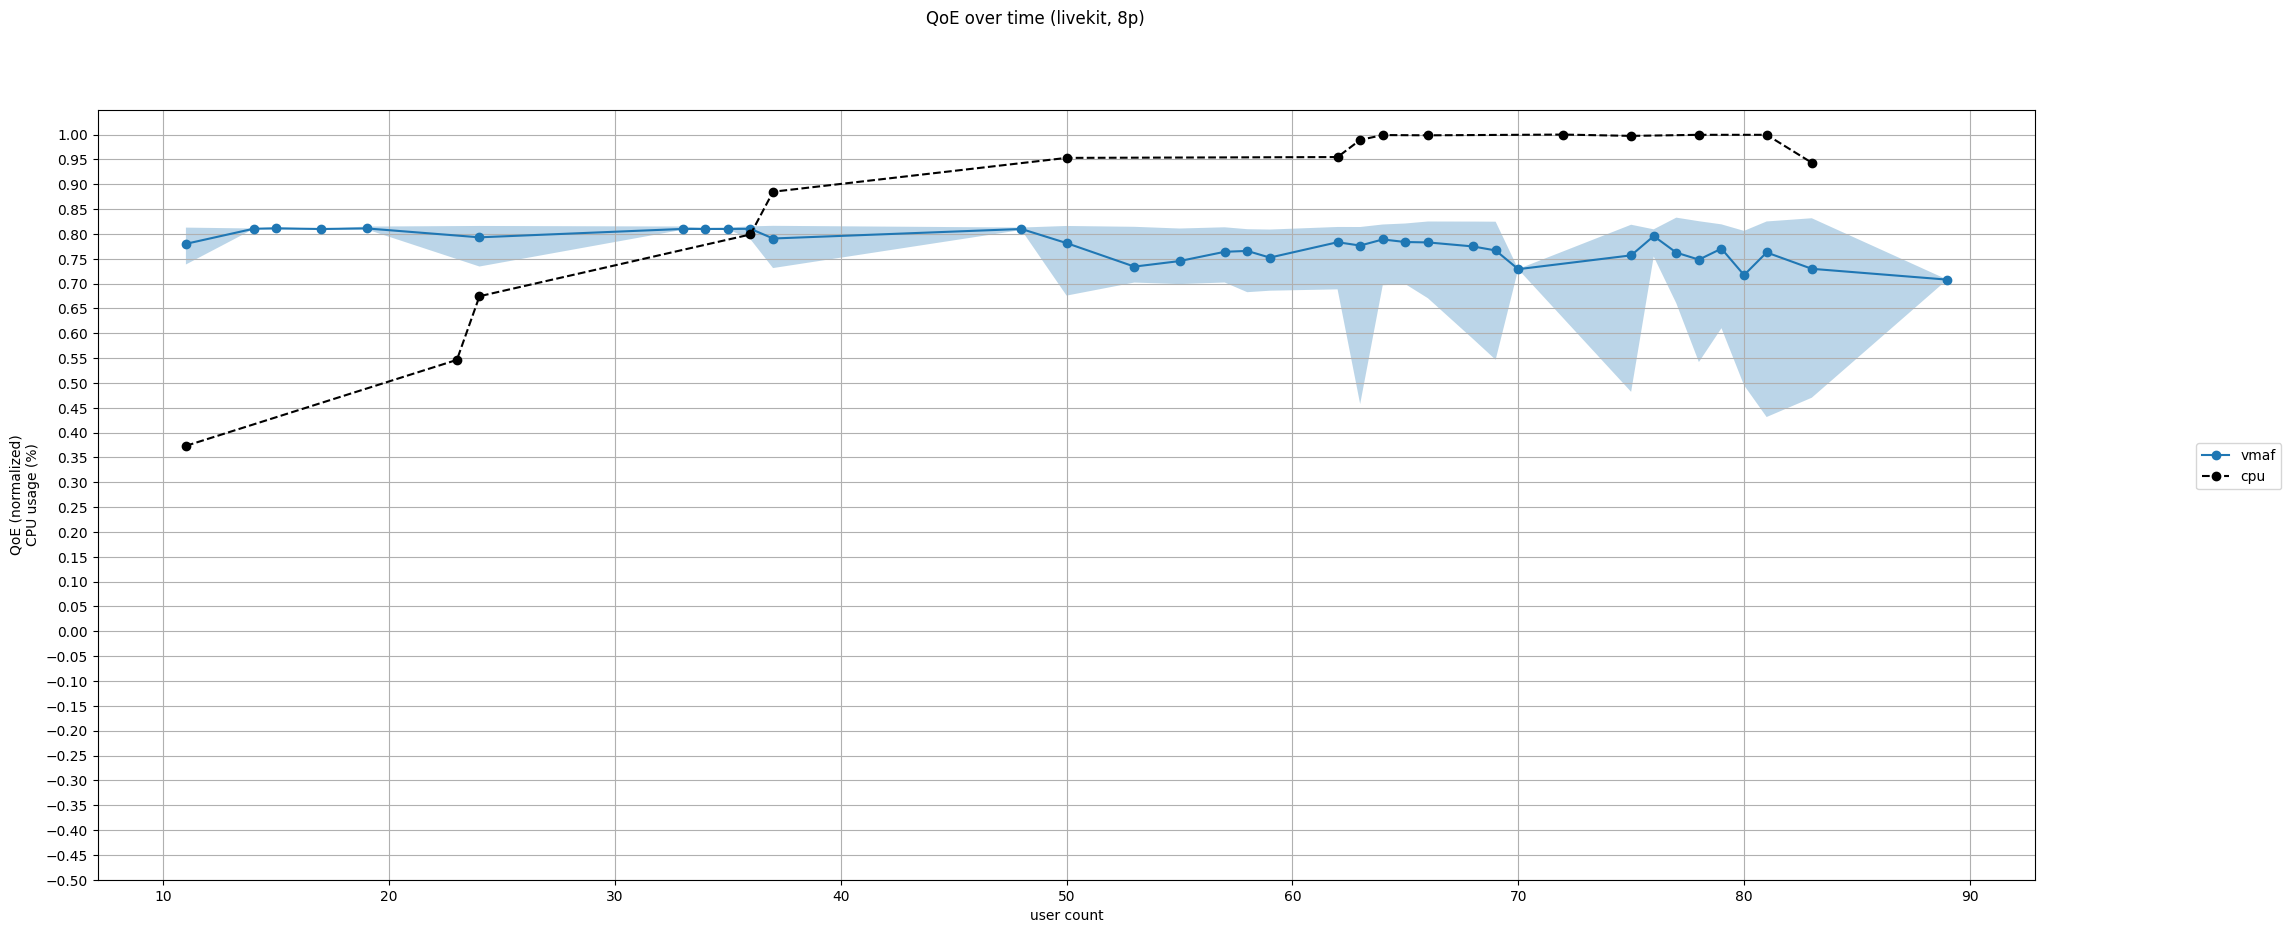

In [12]:
plt.rcParams["figure.figsize"] = [25, 10]
typologies = ["2p", "8p"]
media_nodes = ["kurento", "livekit"]
colors = ["blue", "red"]
metric = "vmaf"
for typology in typologies:
    for media_node in media_nodes:

        fig, ax = plt.subplots()
        #also draw scatterplot
        #figs, axs = plt.subplots()
        target_names = filter(
            lambda x: typology in x and media_node in x and "retry" in x, index_list_names
        )
        #max_x = -1
        for i, target_name in enumerate(target_names):
            df_tmp = df_list[index_list_names.index(target_name)].copy()
            #df_tmp = pd.read_csv(f"dfs_final/{target_name}.csv")
            user_join = pd.read_csv(f"dfs_final/{target_name}-user-join.csv")
            cpu_mem = pd.read_csv(f"dfs_final/{target_name}-medianode.csv")
            user_join = timestamp_to_secs(user_join, target_name)
            cpu_mem = timestamp_to_secs(cpu_mem, target_name)
            cpu_mem = cpu_mem.drop(columns=["memory"]).dropna()
            cpu_mem = cpu_mem.sort_values(by="@timestamp")
            cpu_mem['user_count'] = [len(user_join[user_join['@timestamp'] <= ts]) for ts in cpu_mem['@timestamp']]
            cpu_mem = cpu_mem[cpu_mem['user_count'] > 0]
            cpu_mem = cpu_mem.groupby('user_count').mean(numeric_only=True)
            # remove entries with cpu < 0.001
            # df_node = df_node[df_node["cpu"] > 0.001]
            #df_node = timestamp_to_secs(df_node, target_name)
            # aproximate cut_index to the nearest 10 seconds
            # max_timestamp = df_tmp["cut_index"].max()
            # if df_tmp["cut_index"].max() > 8000:
            #     #df_tmp["cut_index"] = df_tmp["cut_index"].round(-3)
            # #elif df_tmp["cut_index"].max() > 1000:
            #     #df_tmp["cut_index"] = df_tmp["cut_index"].round(-2)
            # else:
            # df_tmp["cut_index"] = df_tmp["cut_index"].round(-1)
            # for metric in qoe_metrics_normalized:
            #     axs.scatter(df_tmp["user_count"], df_tmp[metric], label=metric)
            df_mean = df_tmp.groupby(["user_count"]).mean(numeric_only=True)
            df_min = df_tmp.groupby(["user_count"]).min(numeric_only=True)
            df_max = df_tmp.groupby(["user_count"]).max(numeric_only=True)

            plot_name = target_name

            if not df_mean.empty:
                # TODO: Probar usando eje X user_count
                # TODO: Calcular media y std
                # TODO: Cuanto tarda en meterse X numero de usuarios en un media server
                # TODO: Tiempo de conexión vs número de usuarios (a lo mejor meter CPU)
                ax.plot(df_mean.index, df_mean[metric], label=metric, marker='o')
                ax.fill_between(df_mean.index, df_min[metric], df_max[metric], alpha=0.3)
            ax.plot(cpu_mem.index, cpu_mem["cpu"], label="cpu", linestyle="--", color="black", marker='o')

        ax.set_xlabel("user count")
        ax.set_ylabel("QoE (normalized)\nCPU usage (%)")
        ax.grid()
        ax.set_ylim(-0.5, 1.05)
        ax.set_yticks(np.arange(-0.5, 1.05, 0.05))

        fig.suptitle(f"QoE over time ({media_node}, {typology})")
        fig.legend(loc="right")
        fig.savefig(f"images_final/{typology}_{media_node}_qoe_usercount.png")

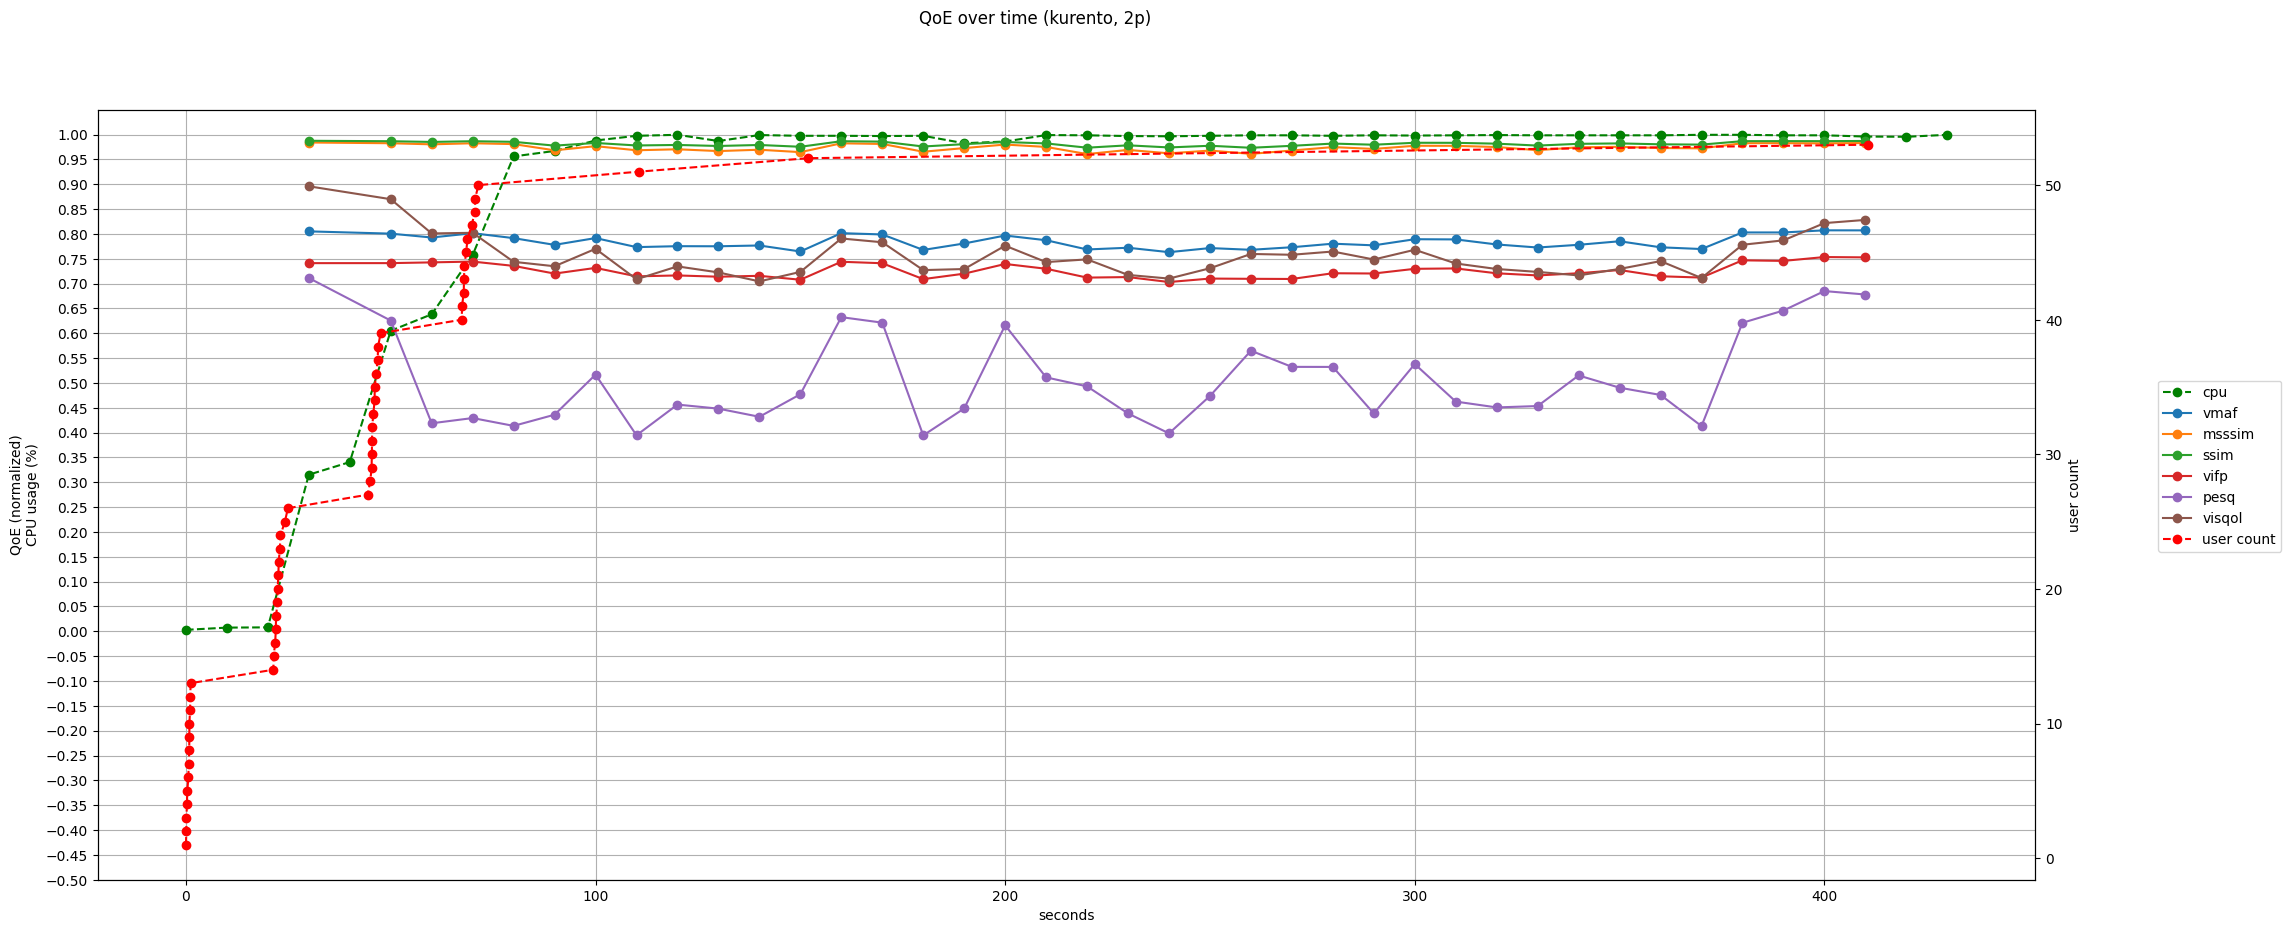

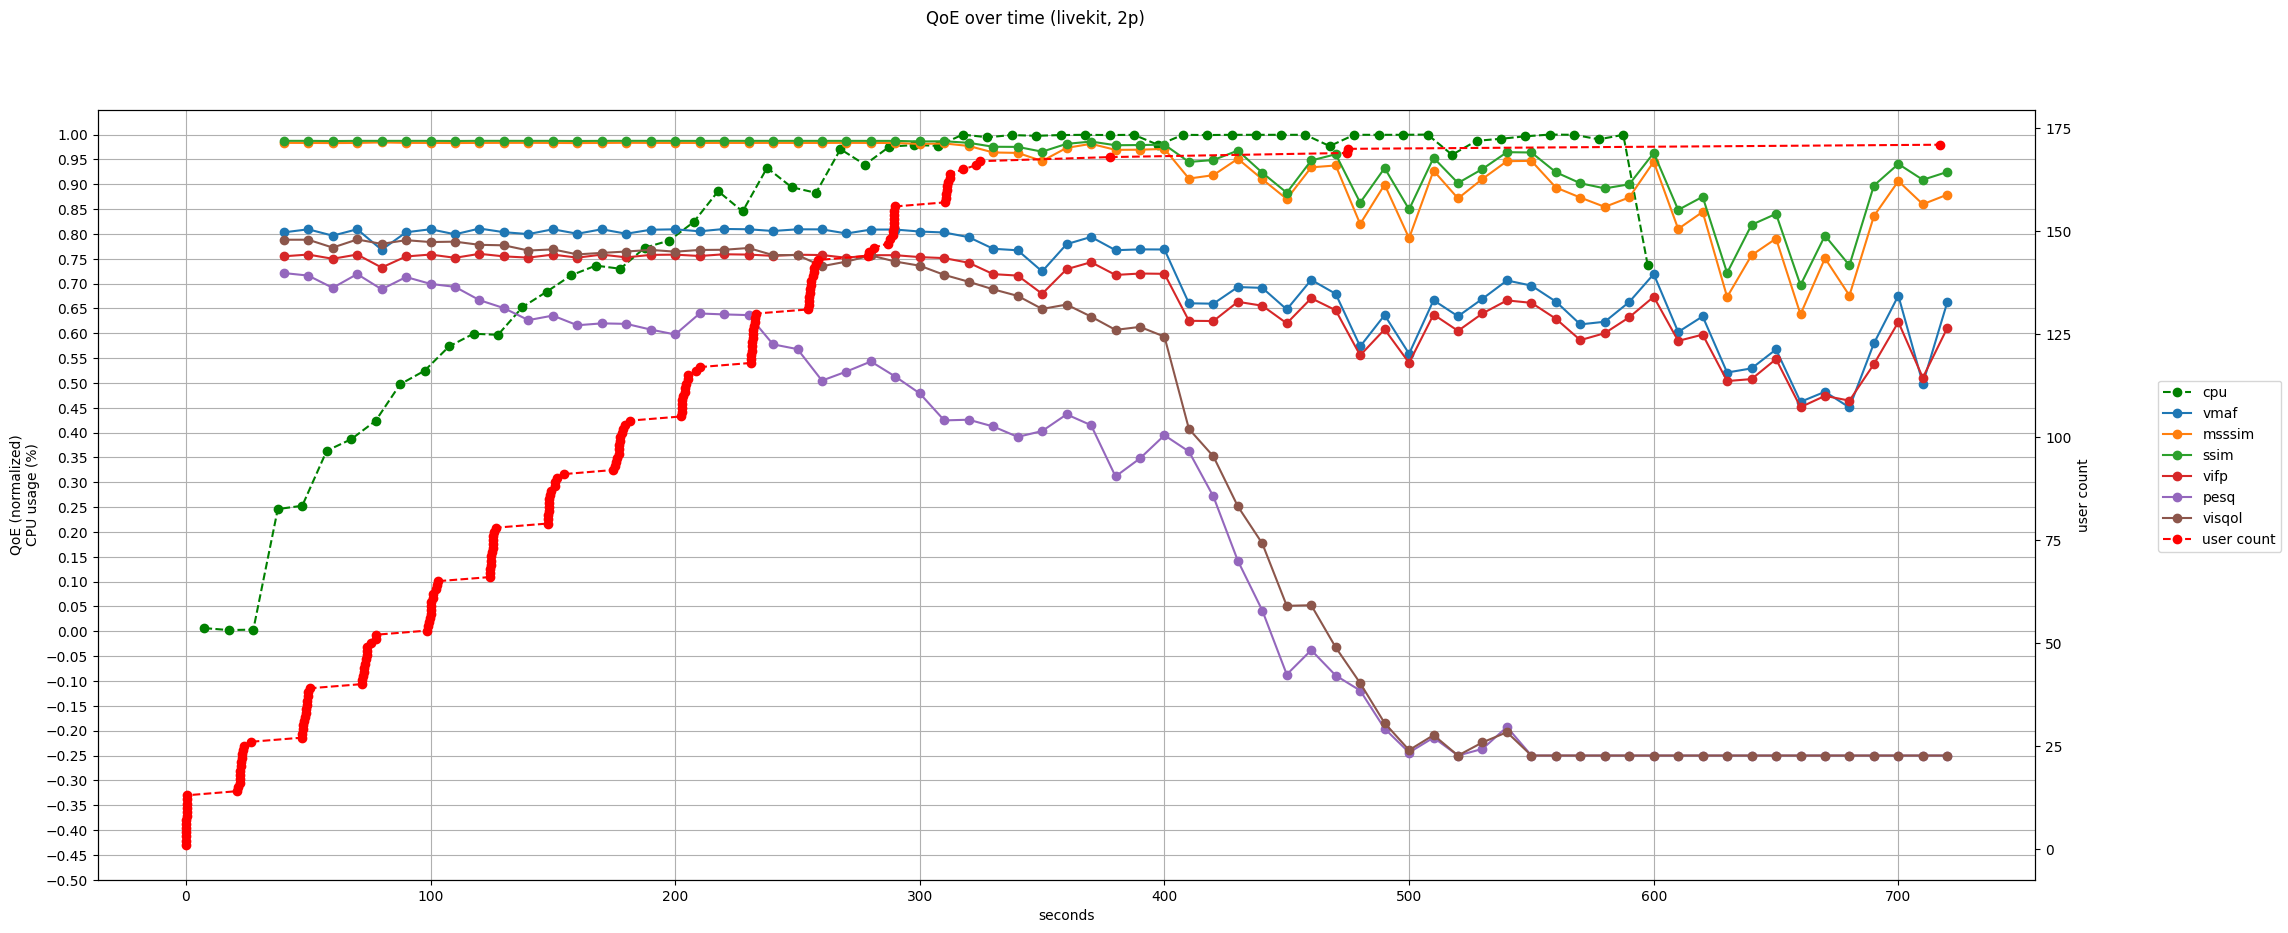

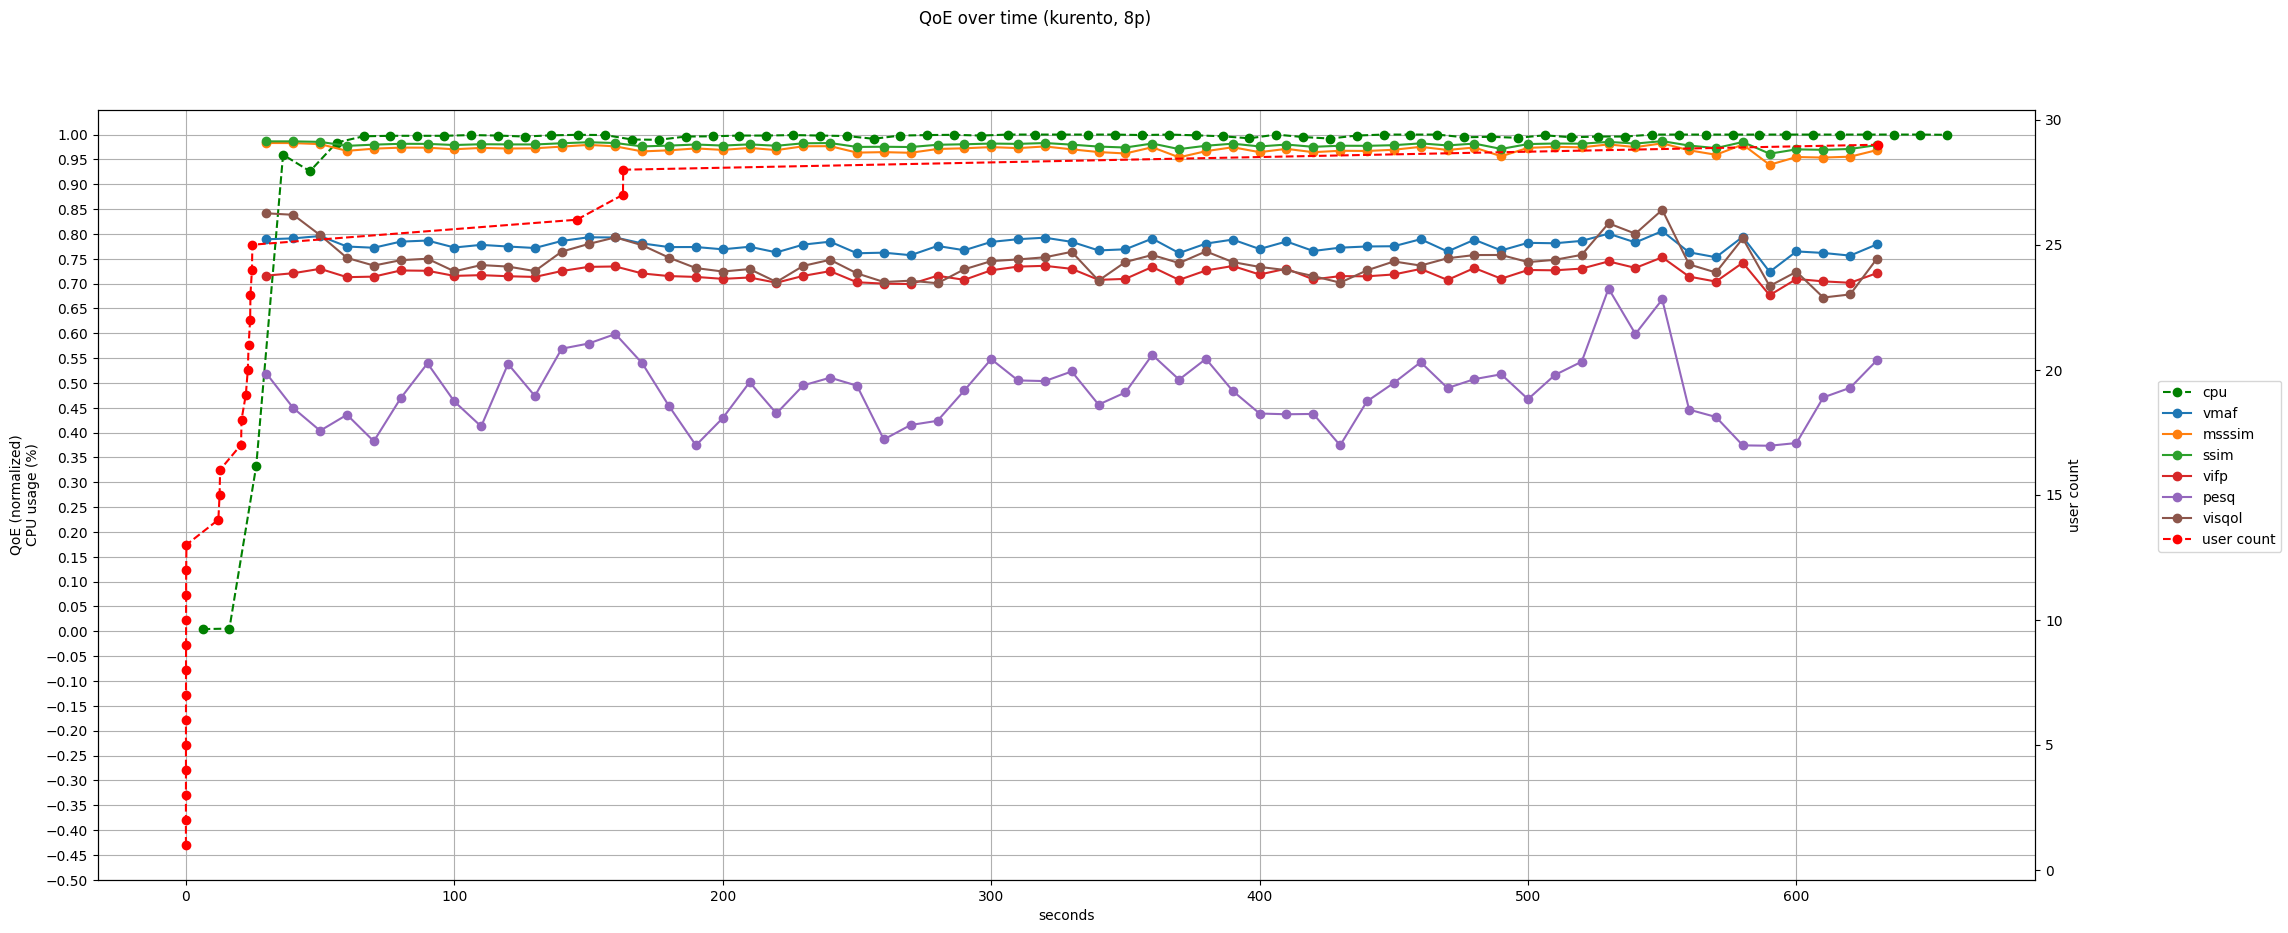

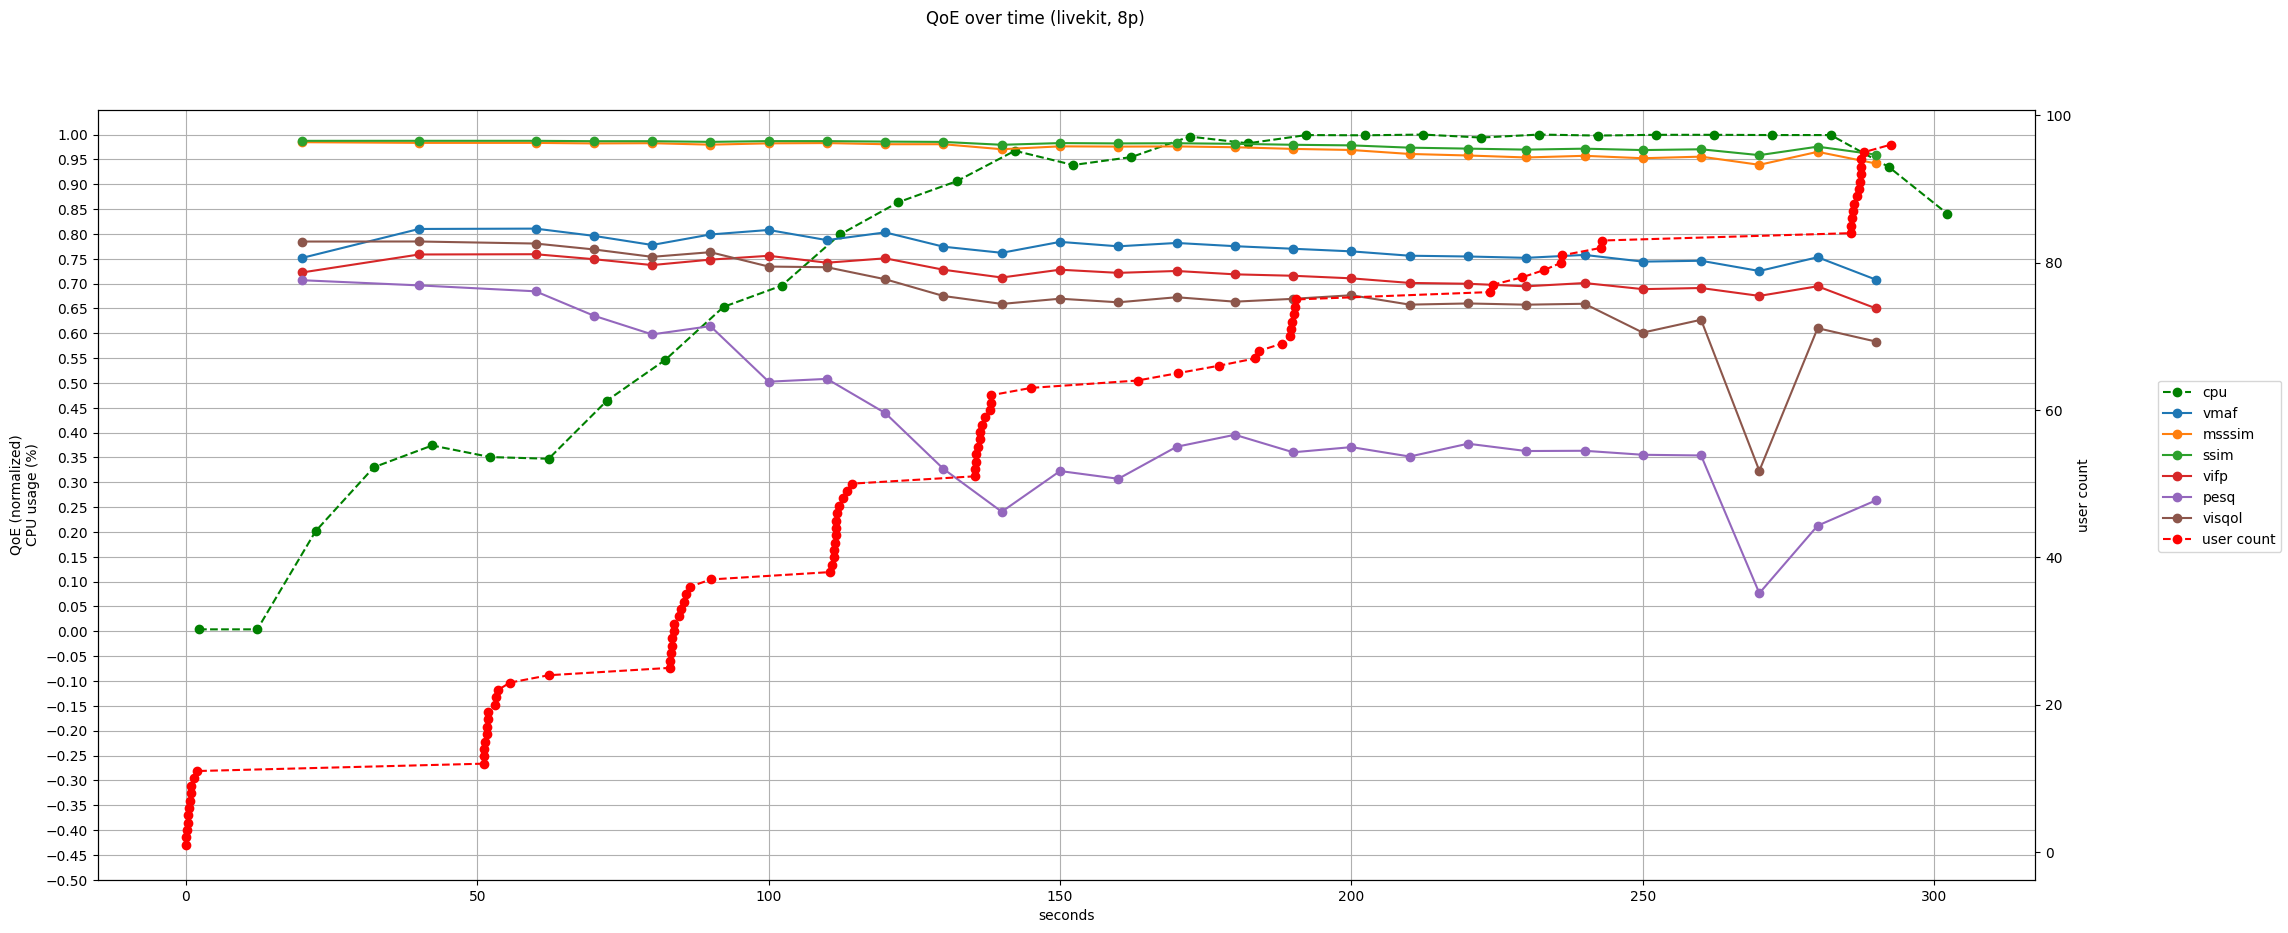

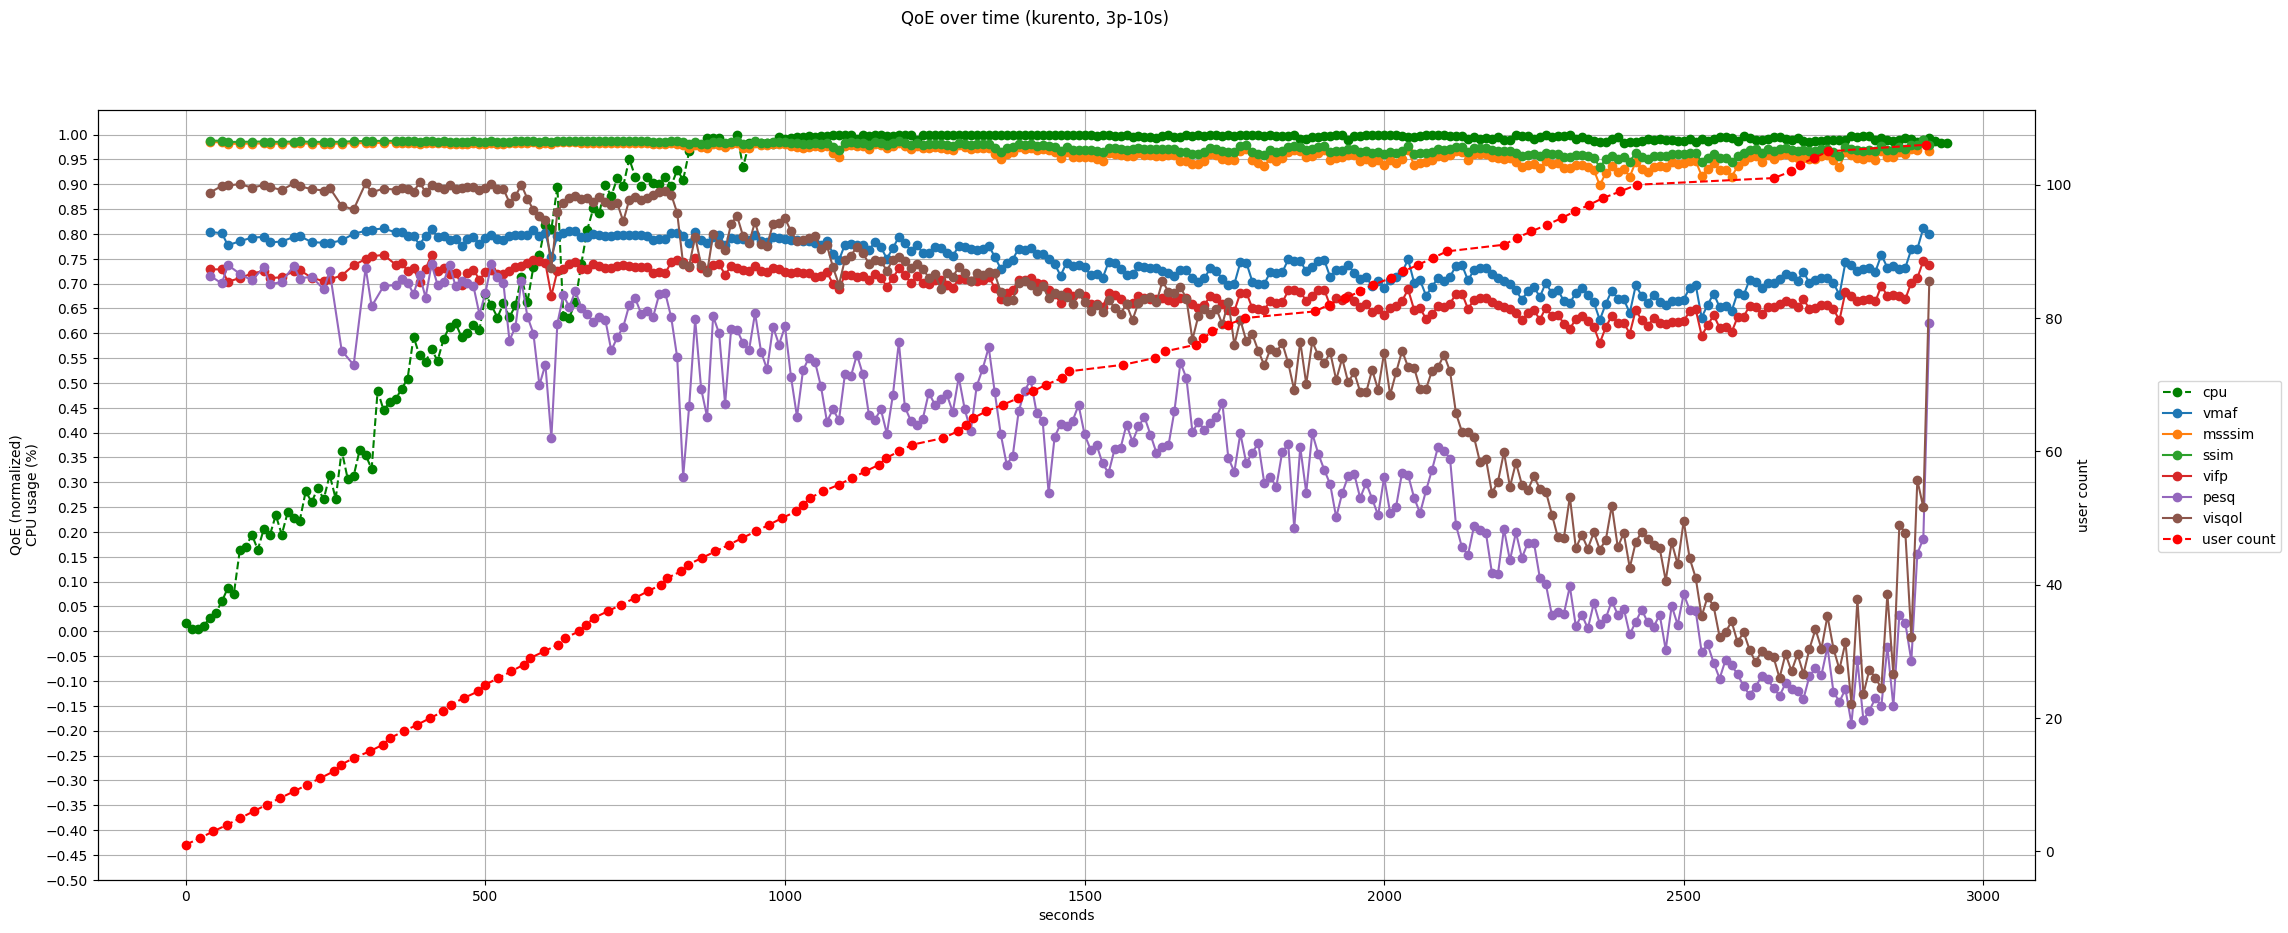

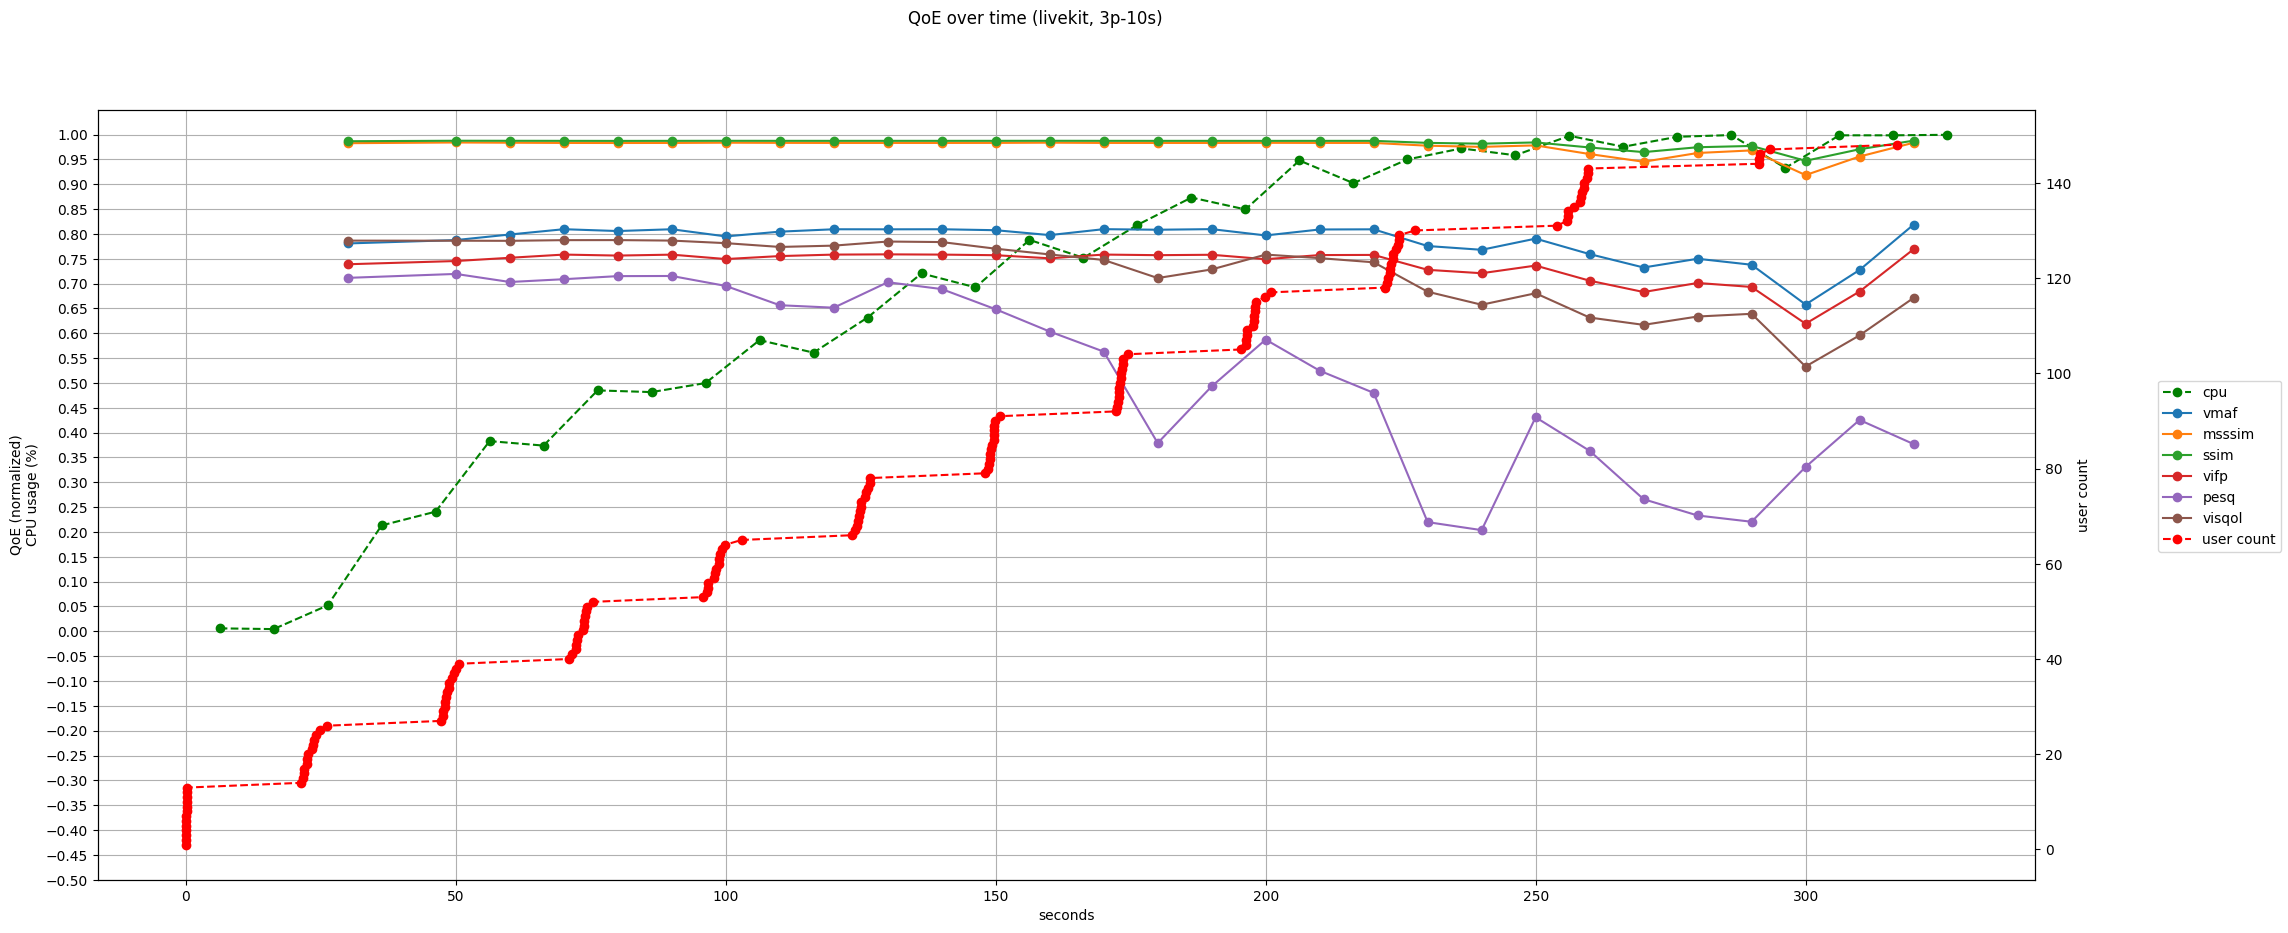

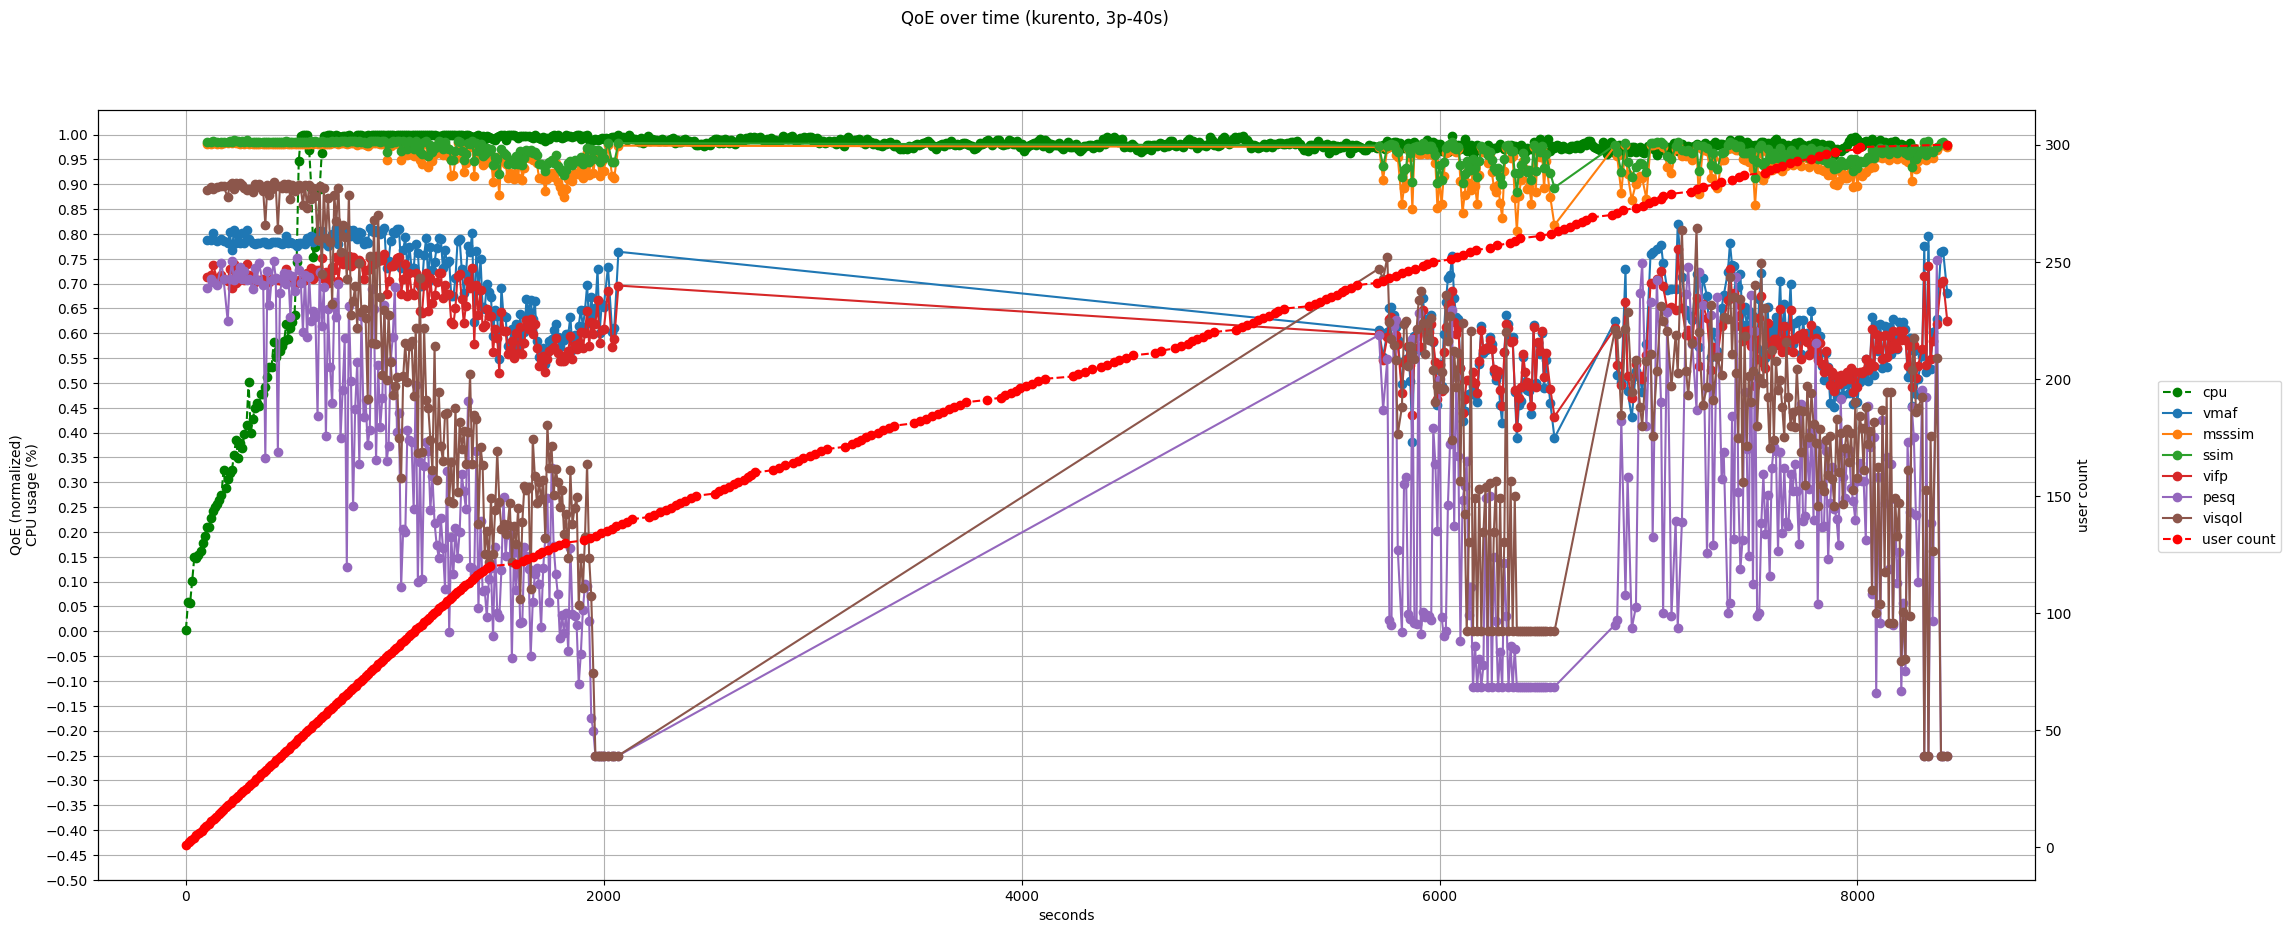

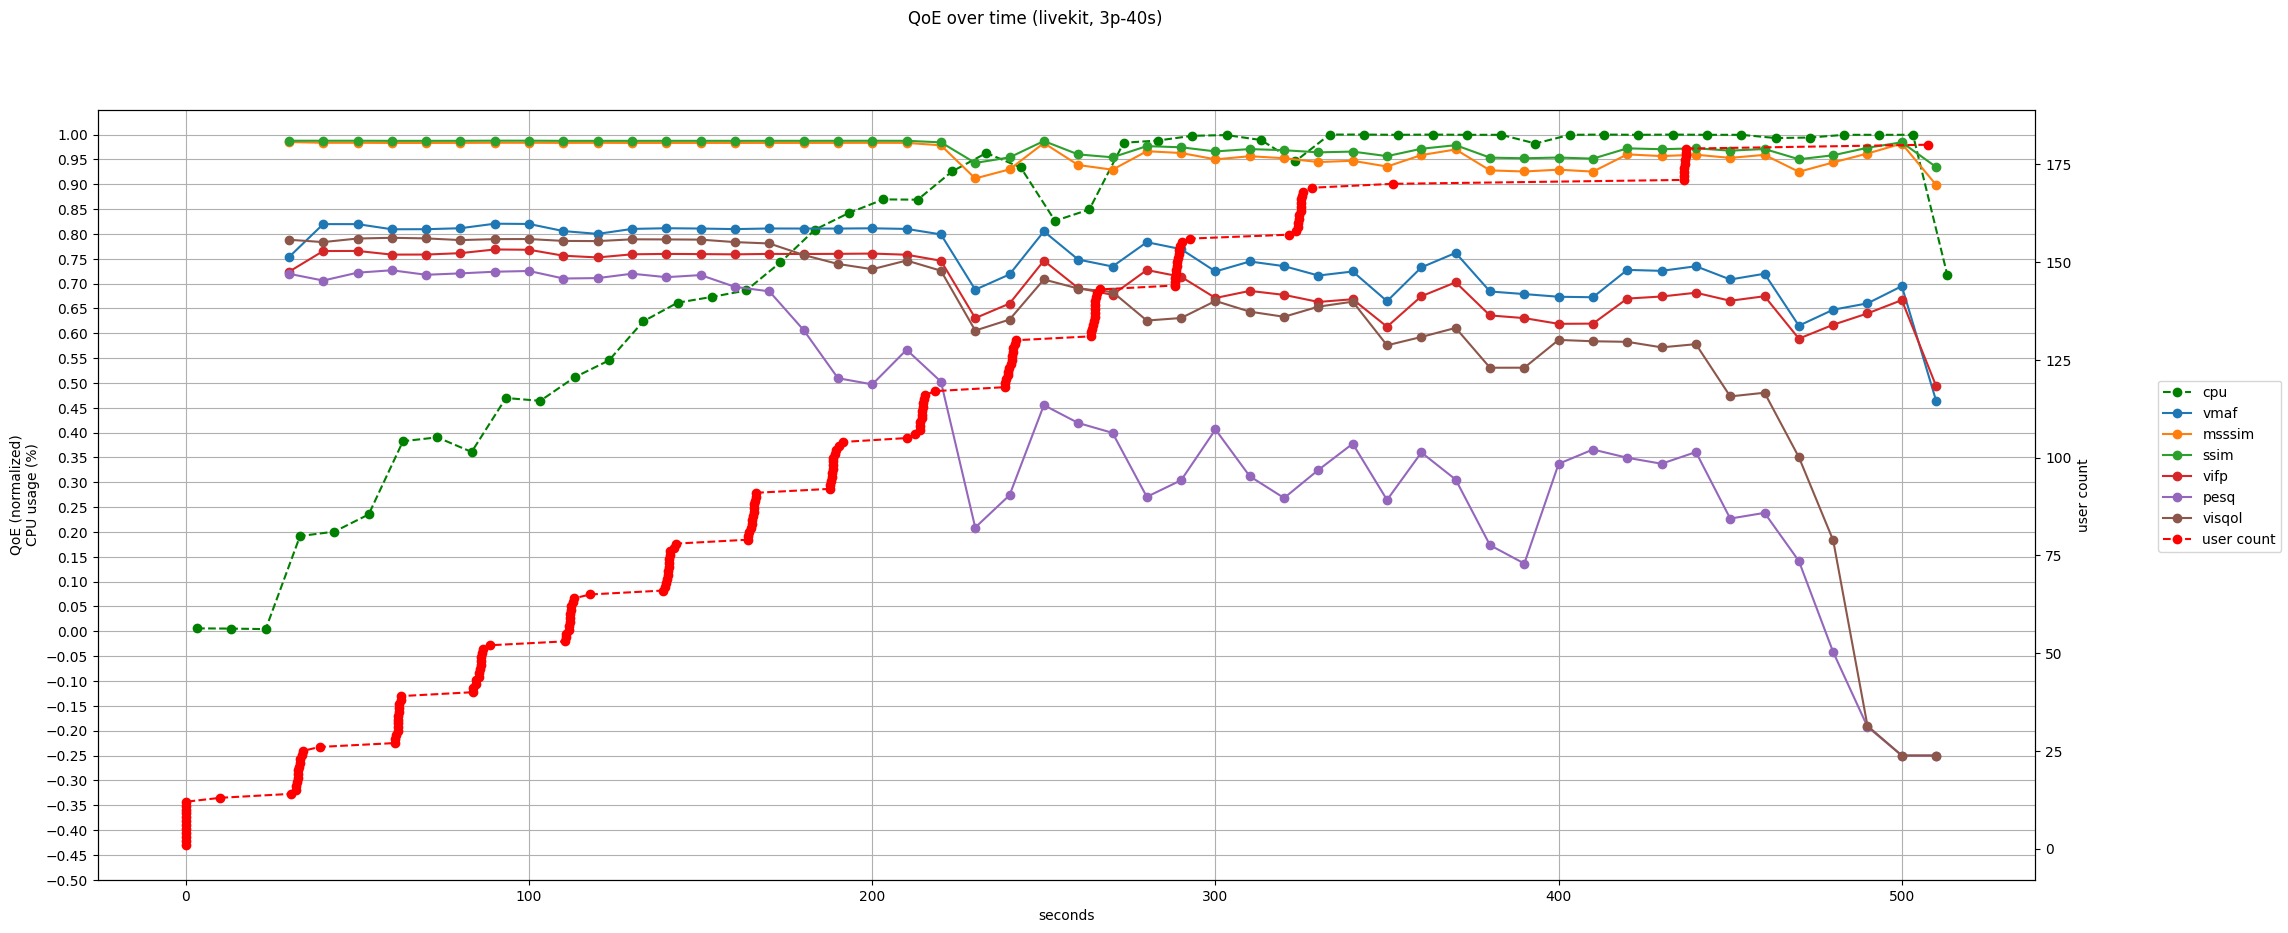

In [14]:
plt.rcParams["figure.figsize"] = [25, 10]
typologies = ["2p", "8p", "3p-10s", "3p-40s"]
media_nodes = ["kurento", "livekit"]
colors = ["blue", "red"]
for typology in typologies:
    for media_node in media_nodes:
        fig, ax = plt.subplots()
        target_names = filter(
            lambda x: typology in x and media_node in x and "retry" in x, index_list_names
        )
        #max_x = -1
        for i, target_name in enumerate(target_names):
            df_tmp = df_list[index_list_names.index(target_name)].copy()
            #df_tmp = pd.read_csv(f"dfs_final/{target_name}.csv")
            user_join = pd.read_csv(f"dfs_final/{target_name}-user-join.csv")
            cpu_mem = pd.read_csv(f"dfs_final/{target_name}-medianode.csv")
            user_join = timestamp_to_secs(user_join, target_name)
            cpu_mem = timestamp_to_secs(cpu_mem, target_name)
            cpu_mem = cpu_mem.drop(columns=["@timestamp", "memory"]).dropna()
            # remove entries with cpu < 0.001
            # df_node = df_node[df_node["cpu"] > 0.001]
            #df_node = timestamp_to_secs(df_node, target_name)
            # aproximate cut_index to the nearest 10 seconds
            max_timestamp = df_tmp["cut_index"].max()
            # if df_tmp["cut_index"].max() > 8000:
            #     #df_tmp["cut_index"] = df_tmp["cut_index"].round(-3)
            # #elif df_tmp["cut_index"].max() > 1000:
            #     #df_tmp["cut_index"] = df_tmp["cut_index"].round(-2)
            # else:
            df_tmp["cut_index"] = df_tmp["cut_index"].round(-1)
            df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)

            plot_name = target_name
            timestamp_user_values = user_join["timestamp_secs"].values
            # fill the timestamp_user_values with the last value to make the plot continuous

            timestamp_user_values = np.append(timestamp_user_values, max_timestamp)
            count = range(1, len(timestamp_user_values) + 1)
            if i == 0:
                ax2 = ax.twinx()
                ax2.plot(timestamp_user_values, count, color="red", label="user count", linestyle="--", marker="o")
                ax2.set_ylabel("user count")
                #ax3 = ax.twinx()
                ax.plot(cpu_mem["timestamp_secs"], cpu_mem["cpu"], color="green", label="cpu", linestyle="--", marker="o")
                #ax2.set_ylabel("cpu")


            if not df_mean.empty:
                for metric in qoe_metrics_normalized:
                    # TODO: Probar usando eje X user_count
                    # TODO: Calcular media y std
                    # TODO: Cuanto tarda en meterse X numero de usuarios en un media server
                    # TODO: Tiempo de conexión vs número de usuarios (a lo mejor meter CPU)
                    ax.plot(df_mean.index, df_mean[metric], label=metric, marker="o")

        ax.set_xlabel("seconds")
        ax.set_ylabel("QoE (normalized)\nCPU usage (%)")
        ax.grid()
        ax.set_ylim(-0.5, 1.05)
        ax.set_yticks(np.arange(-0.5, 1.05, 0.05))

        fig.suptitle(f"QoE over time ({media_node}, {typology})")
        fig.legend(loc="right")
        fig.savefig(f"images_final/{typology}_{media_node}_qoe.png")